# Utils

In [1]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display
import os
import gc

In [2]:
os.getcwd()

'/home/sungwoopark/rl-practice/bandit/MAB'

In [3]:
model_repr = {
    "mab": "K-armed Bandit", 
    "ucbnaive": "Naive UCB Approach", 
    "ucbdelta": "UCB-delta Algorithm", 
    "ucbasym": "Asymptotically Optimal UCB", 
    "ucbmoss": "UCB MOSS Algorithm", 
    "thompson": "Thompson Sampling",
    "etc": "Explore-then-commit"
}

model_params = {
    "mab": "epsilon", 
    "ucbnaive": "c", 
    "ucbdelta": "delta", 
    "etc": "explore"  
}

In [4]:
def process(df:pd.DataFrame, no_param:bool):
    ## get cumulative reward
    cumsum_base = np.array([], dtype='float')
    for e in df['sim'].unique():
        rundf = df[df['sim'] == e]
        run_cumsum = np.cumsum(rundf['reward'])
        cumsum_base = np.append(cumsum_base, run_cumsum)
    df['cumulative_reward'] = cumsum_base
    
    ## check if the optimal arm is selected at each run
    df['chosen_optimal'] = (df['chosen_arm'] == df['optimal_arm']).astype('int')
    
    ## groupby
    if no_param:
        result = df[['step', 'reward', 'mean_reward', 'cumulative_reward', 
                     'optimal_reward', 'chosen_optimal']].groupby(by='step').mean(numeric_only=False)
    else:
        result = df[['param', 'step', 'reward', 'mean_reward', 'cumulative_reward', 
                     'optimal_reward', 'chosen_optimal']].groupby(by=['param', 'step']).mean(numeric_only=False)
    result.reset_index(drop=False, inplace=True)
    
    return result

In [5]:
def procedure(fname, no_param):
    with open(fname, "rb") as f:
        obj = pickle.load(f)
    
    processed = []
    for df in tqdm(obj):
        processed.append(process(df, no_param))
    
    del obj
    gc.collect()
    return processed

In [6]:
def getregret(dfs:list):
    for item in dfs:
        item['rnd_regret'] = np.cumsum(item['optimal_reward'] - item['reward'])
        item['regret'] = np.cumsum(item['optimal_reward'] - item['mean_reward'])        

In [7]:
def getlabel(colname:str):
    split = colname.split('_')
    split[0] = split[0][0].upper() + split[0][1:]
    label = ' '.join(split)
    return label

In [8]:
def plot_results(dfs, model, arm, is_regret=False):
    if not is_regret:
        ## chosen optimal and reward analysis
        column = ['chosen_optimal', 'reward']
        figsize = (14, 5)
        
        optimal, reward = column
        optimal_label = getlabel(optimal)
        reward_label = getlabel(reward)

        plt.figure(figsize=figsize)

        plt.subplot(121)
        for item in dfs:
            if model in ["thompson", "ucbasym", "ucbmoss"]:
                label = f"{model_repr[model]}"
            else:
                if item['param'].iloc[0] > 1e-5:
                    label = f"{model_params[model]}={item['param'].iloc[0]}"
                else:
                    label = f"{model_params[model]}={item['param'].iloc[0]:.6f}"
            plt.plot(item[optimal], label=label)
        plt.legend()
        plt.grid(True)
        plt.xlabel("Step")
        plt.ylabel(f"{optimal_label} %")
        plt.title(f"{model_repr[model]} {optimal_label} % - {arm} Arm")

        plt.subplot(122)
        for item in dfs:
            if model in ["thompson", "ucbasym", "ucbmoss"]:
                label = f"{model_repr[model]}"
            else:
                label = f"{model_params[model]}={item['param'].iloc[0]:.6f}"
            plt.plot(item[reward], label=label)
        plt.legend()
        plt.grid(True)
        plt.xlabel("Step")
        plt.ylabel(reward_label)
        plt.title(f"{model_repr[model]} {reward_label} - {arm} Arm")
    
    else:
        ## regret analysis
        column = 'regret'
        figsize = (7, 5)
    
        ylabel = getlabel(column)
        max_val = 0
        plt.figure(figsize=figsize)
        for item in dfs:
            if model in ["thompson", "ucbasym", "ucbmoss"]:
                label = f"{model_repr[model]}"
            else:
                if item['param'].iloc[0] > 1e-5:
                    label = f"{model_params[model]}={item['param'].iloc[0]}"
                else:
                    label = f"{model_params[model]}={item['param'].iloc[0]:.6f}"
            plt.plot(item[column], label=label)
            max_val = np.maximum(max_val, item[column].max())
        plt.plot(plt.xlim(), plt.xlim(), color='red', linestyle=':', label='45 degree')
        plt.plot(plt.xlim(), (0, max_val), color='blue', linestyle=':', label='linear regret')
        plt.legend()
        plt.grid(True)
        plt.xlabel("Step")
        plt.ylabel(ylabel)
        plt.title(f"{model_repr[model]} {ylabel} - {arm} Arm")
    
    plt.tight_layout()
    plt.show()

In [9]:
def summary(dfs, model, column, greedy, is_optimistic=False, is_regret=False):
    if is_optimistic:
        flag = "Optimistic "
    else:
        flag = ""
    
    means = [item[column].mean() for item in dfs]
    if column != "regret":
        arg = np.argmax(means)
    else:
        arg = np.argmin(means)

    if greedy:
        label = f"{flag}{model_repr[model]}, greedy"
        arg = 0
    else:
        best_param = dfs[arg]['param'].iloc[0]
        label = f"{flag}{model_repr[model]}, {model_params[model]}={best_param}"
    
    return arg, label

# Definite Case

In [10]:
os.chdir("./definite")
!ls

eGreedyMAB_BernoulliArm_0.5_Naive_results.pkl
eGreedyMAB_BernoulliArm_0.5_Optimistic_results.pkl
eGreedyMAB_BernoulliArm_1.0_Naive_results.pkl
eGreedyMAB_BernoulliArm_1.0_Optimistic_results.pkl
eGreedyMAB_GaussianArm_0.5_Naive_results.pkl
eGreedyMAB_GaussianArm_0.5_Optimistic_results.pkl
eGreedyMAB_GaussianArm_1.0_Naive_results.pkl
eGreedyMAB_GaussianArm_1.0_Optimistic_results.pkl
ETC_BernoulliArm_1.0_Naive_results.pkl
ETC_GaussianArm_1.0_Naive_results.pkl
ThompsonSampling_BernoulliArm_1.0_Naive_results.pkl
ThompsonSampling_GaussianArm_1.0_Naive_results.pkl
UCBAsymptotic_BernoulliArm_1.0_Naive_results.pkl
UCBAsymptotic_GaussianArm_1.0_Naive_results.pkl
UCBDelta_BernoulliArm_1.0_Naive_results.pkl
UCBDelta_GaussianArm_1.0_Naive_results.pkl
UCBMOSS_BernoulliArm_1.0_Naive_results.pkl
UCBMOSS_GaussianArm_1.0_Naive_results.pkl
UCBNaive_BernoulliArm_1.0_Naive_results.pkl
UCBNaive_GaussianArm_1.0_Naive_results.pkl


## Naive Multi-Armed Bandit

### $\alpha$=1

In [11]:
mab_bern_1 = procedure(fname="./eGreedyMAB_BernoulliArm_1.0_Naive_results.pkl", no_param=False)
mab_gaus_1 = procedure(fname="./eGreedyMAB_GaussianArm_1.0_Naive_results.pkl", no_param=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:31<00:00,  5.24s/it]


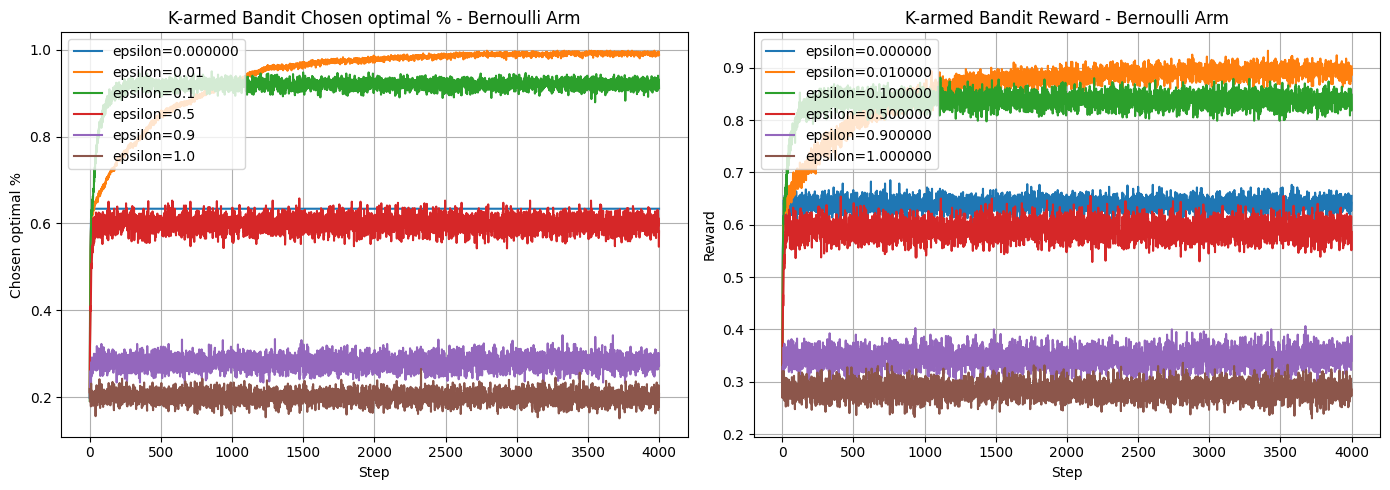

In [12]:
plot_results(mab_bern_1, arm="Bernoulli", model="mab", is_regret=False)

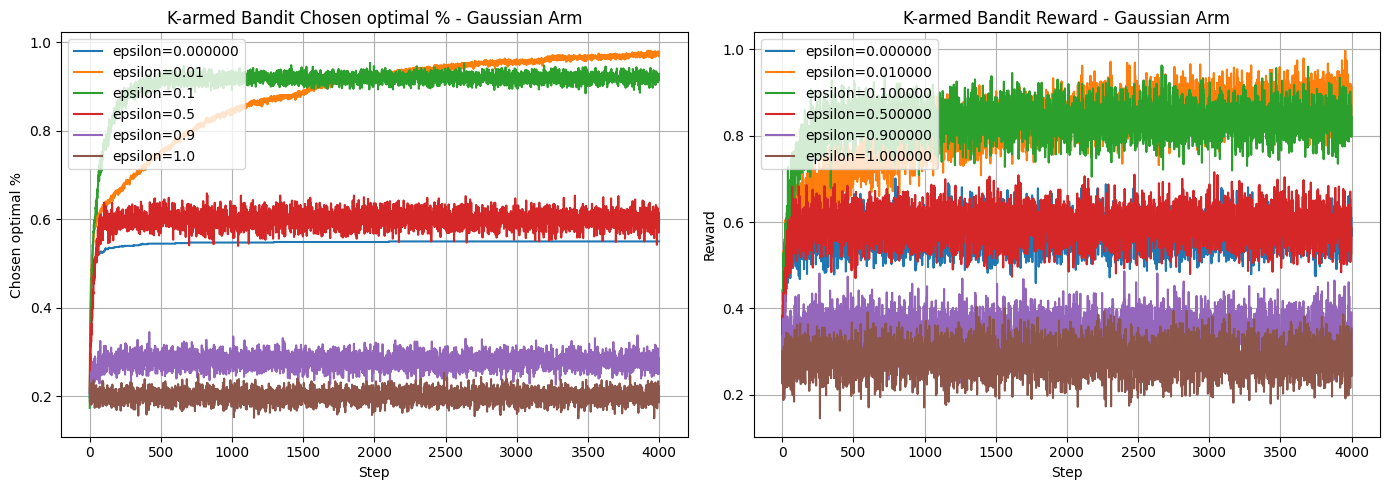

In [13]:
plot_results(mab_gaus_1, arm="Gaussian", model="mab")

### $\alpha$=0.5

In [14]:
mab_bern_half = procedure(fname="./eGreedyMAB_BernoulliArm_0.5_Naive_results.pkl", no_param=False)
mab_gaus_half = procedure(fname="./eGreedyMAB_GaussianArm_0.5_Naive_results.pkl", no_param=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:31<00:00,  5.19s/it]


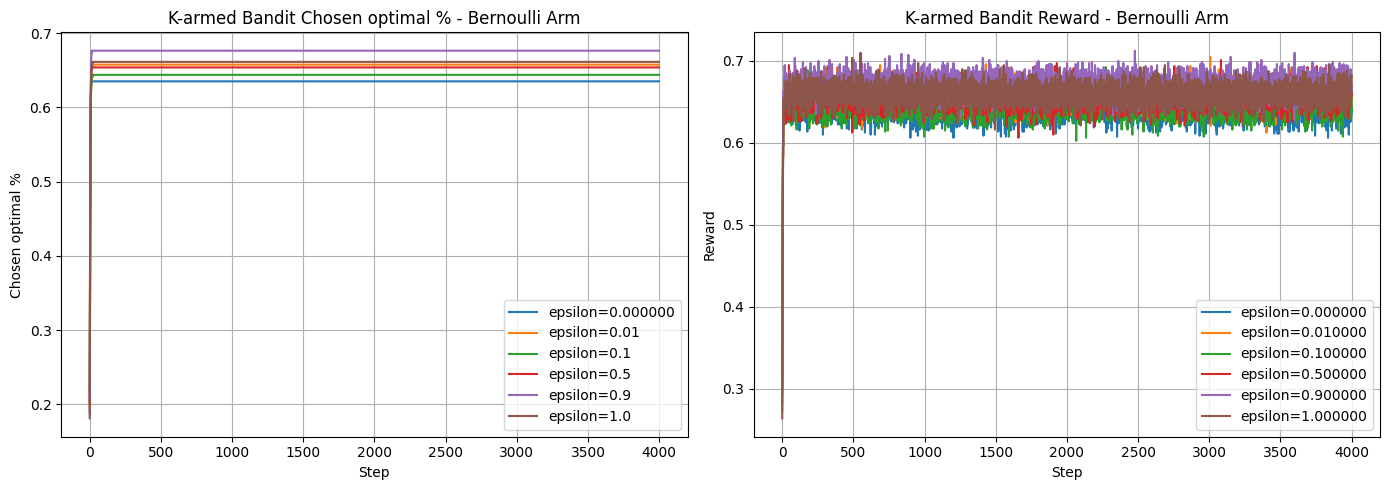

In [15]:
plot_results(mab_bern_half, arm="Bernoulli", model="mab")

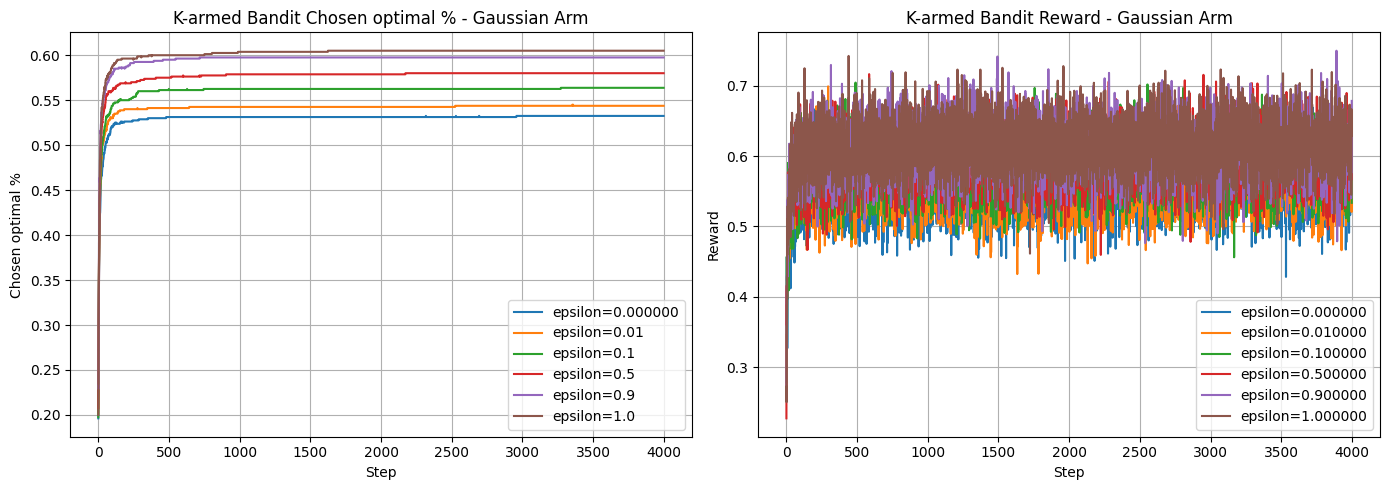

In [16]:
plot_results(mab_gaus_half, arm="Gaussian", model="mab")

## Optimistic Multi-Armed Bandit

### $\alpha$=1

In [17]:
mab_opt_bern_1 = procedure(fname="./eGreedyMAB_BernoulliArm_1.0_Optimistic_results.pkl", no_param=False)
mab_opt_gaus_1 = procedure(fname="./eGreedyMAB_GaussianArm_1.0_Optimistic_results.pkl", no_param=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.07s/it]


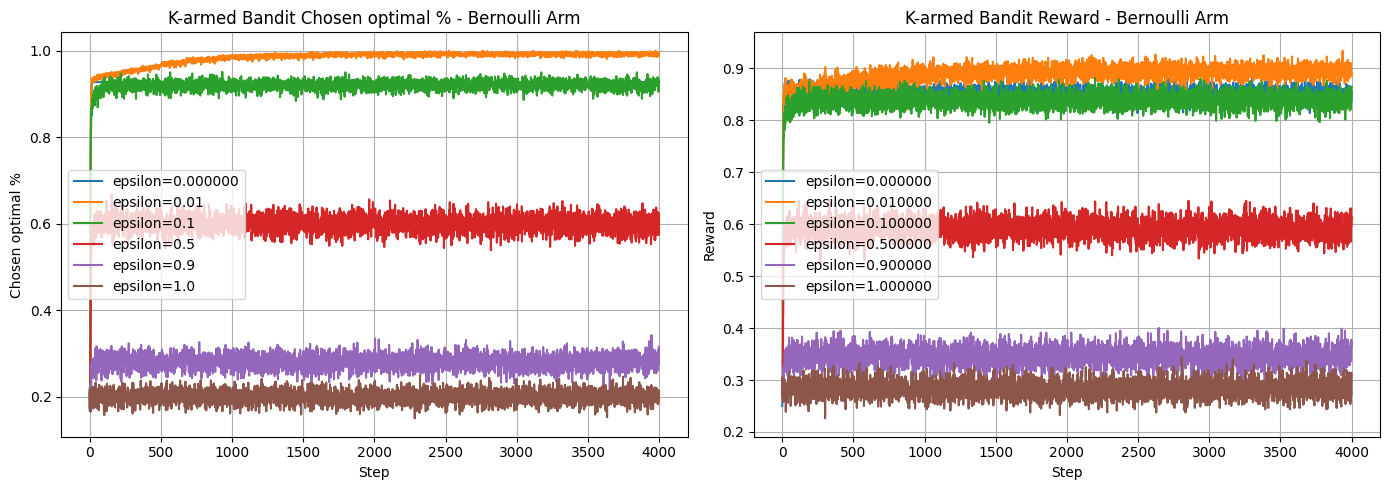

In [18]:
plot_results(mab_opt_bern_1, arm="Bernoulli", model="mab")

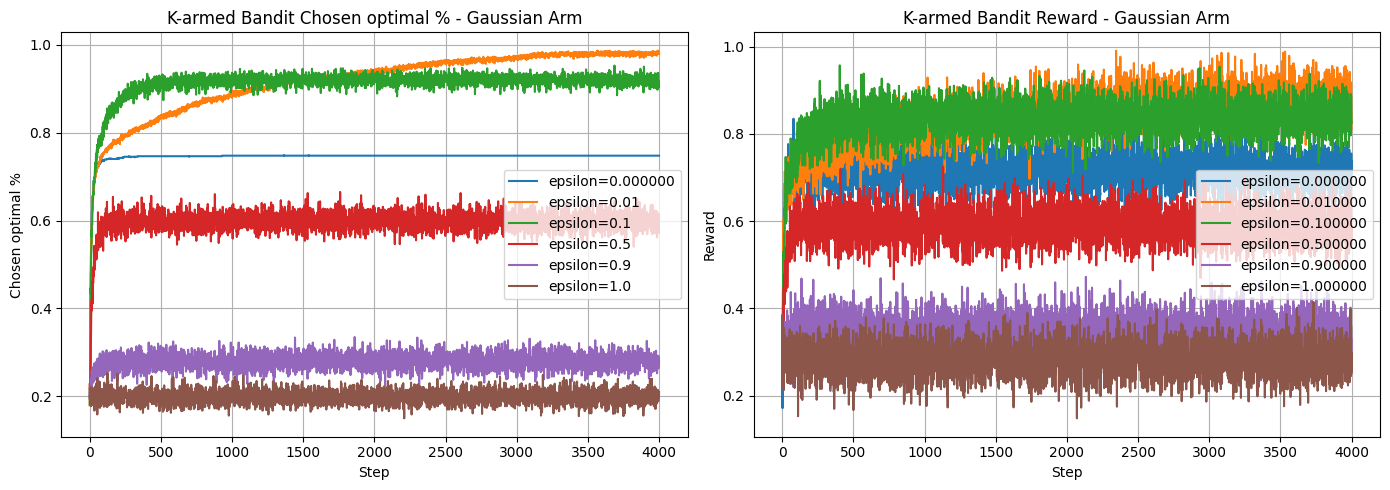

In [19]:
plot_results(mab_opt_gaus_1, arm="Gaussian", model="mab")

### $\alpha$=0.5

In [20]:
mab_opt_bern_half = procedure(fname="./eGreedyMAB_BernoulliArm_0.5_Optimistic_results.pkl", no_param=False)
mab_opt_gaus_half = procedure(fname="./eGreedyMAB_GaussianArm_0.5_Optimistic_results.pkl", no_param=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.11s/it]


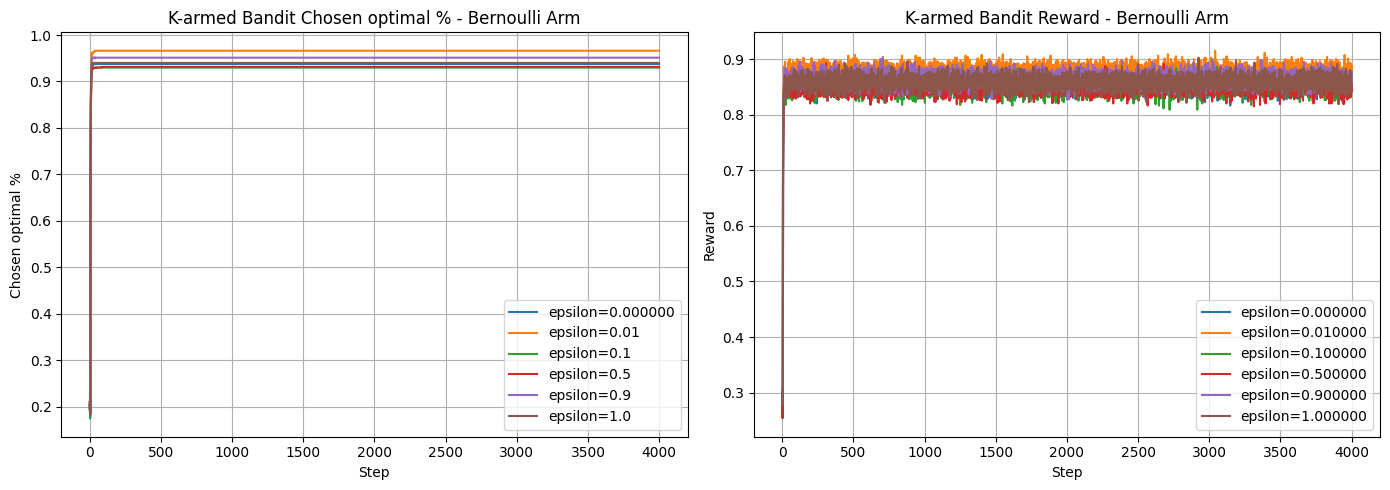

In [21]:
plot_results(mab_opt_bern_half, arm="Bernoulli", model="mab")

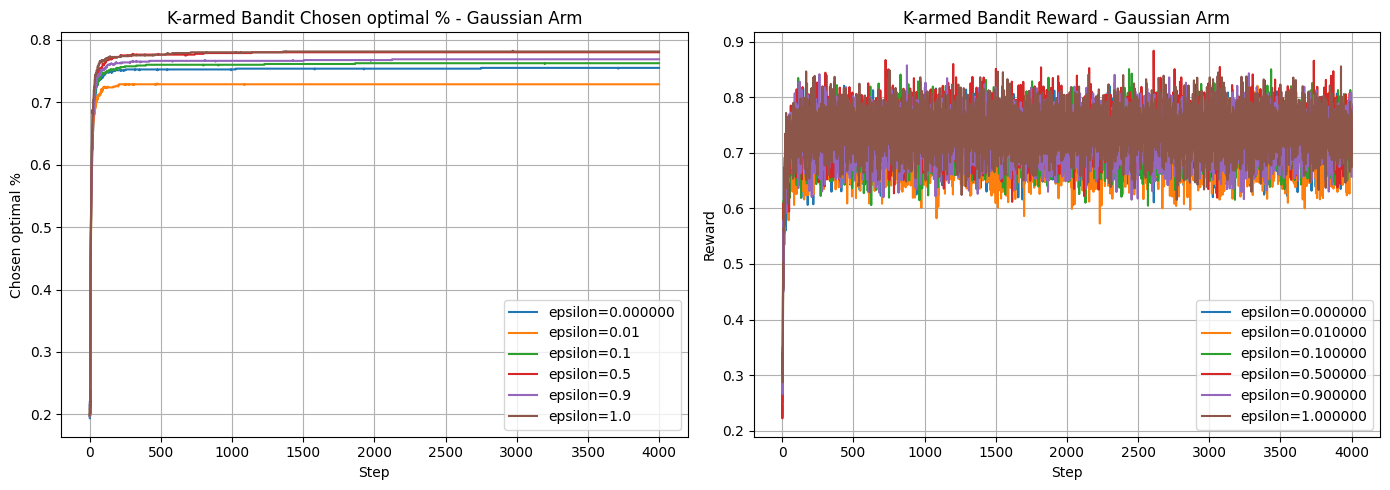

In [22]:
plot_results(mab_opt_gaus_half, arm="Gaussian", model="mab")

## Comparison - Naive vs Optimistic

### Bernoulli $\alpha$=1

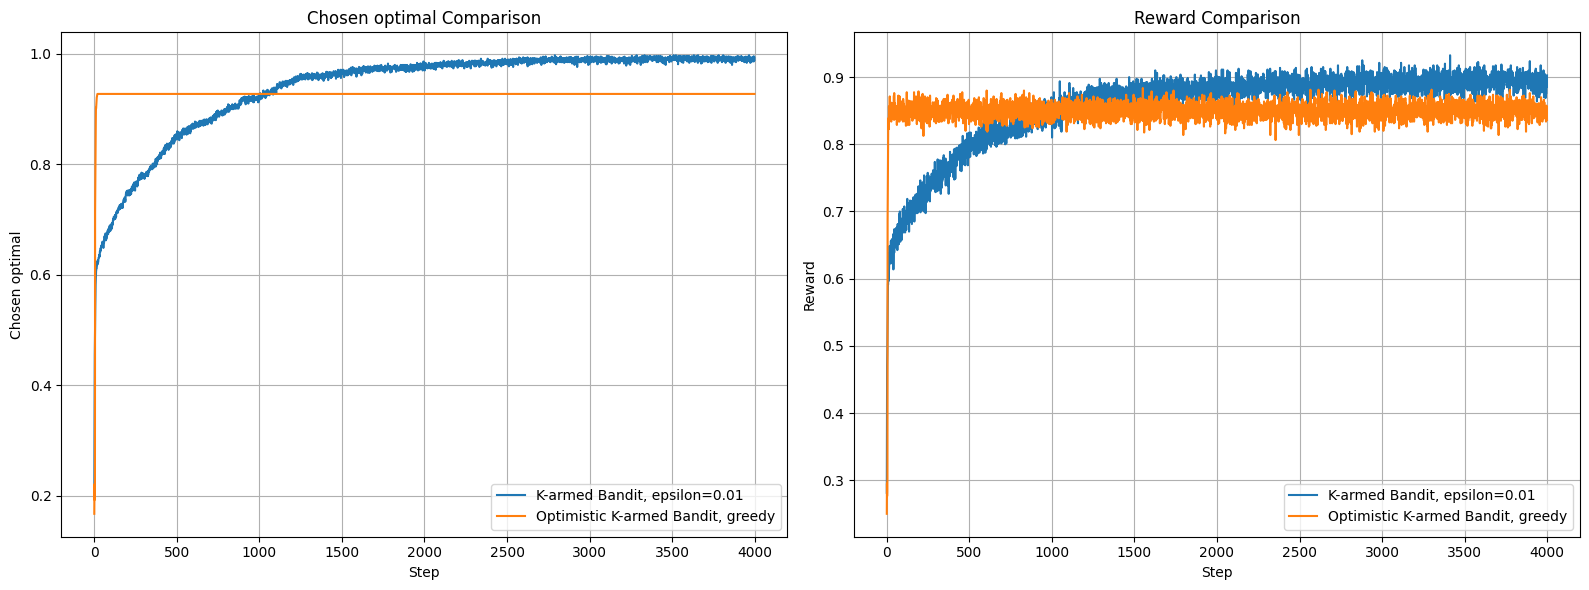

In [23]:
figsize = (16, 6)

model1, model2 = "mab", "mab"

column1 = 'chosen_optimal'
ylabel1 = getlabel(column1)
argmax1_col1, label1_col1 = summary(mab_bern_1, model1, column1, greedy=False, is_optimistic=False)
argmax2_col1, label2_col1 = summary(mab_opt_bern_1, model2, column1, greedy=True, is_optimistic=True)

column2 = 'reward'
ylabel2 = getlabel(column2)
argmax1_col2, label1_col2 = summary(mab_bern_1, model1, column2, greedy=False, is_optimistic=False)
argmax2_col2, label2_col2 = summary(mab_opt_bern_1, model2, column2, greedy=True, is_optimistic=True)

plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(mab_bern_1[argmax1_col1][column1], label=label1_col1)
plt.plot(mab_opt_bern_1[argmax2_col1][column1], label=label2_col1)
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(ylabel1)
plt.legend()
plt.title(f"{ylabel1} Comparison")

plt.subplot(122)
plt.plot(mab_bern_1[argmax1_col2][column2], label=label1_col2)
plt.plot(mab_opt_bern_1[argmax2_col2][column2], label=label2_col2)
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(ylabel2)
plt.legend()
plt.title(f"{ylabel2} Comparison")

plt.tight_layout()
plt.show()

### Bernoulli $\alpha$=0.5

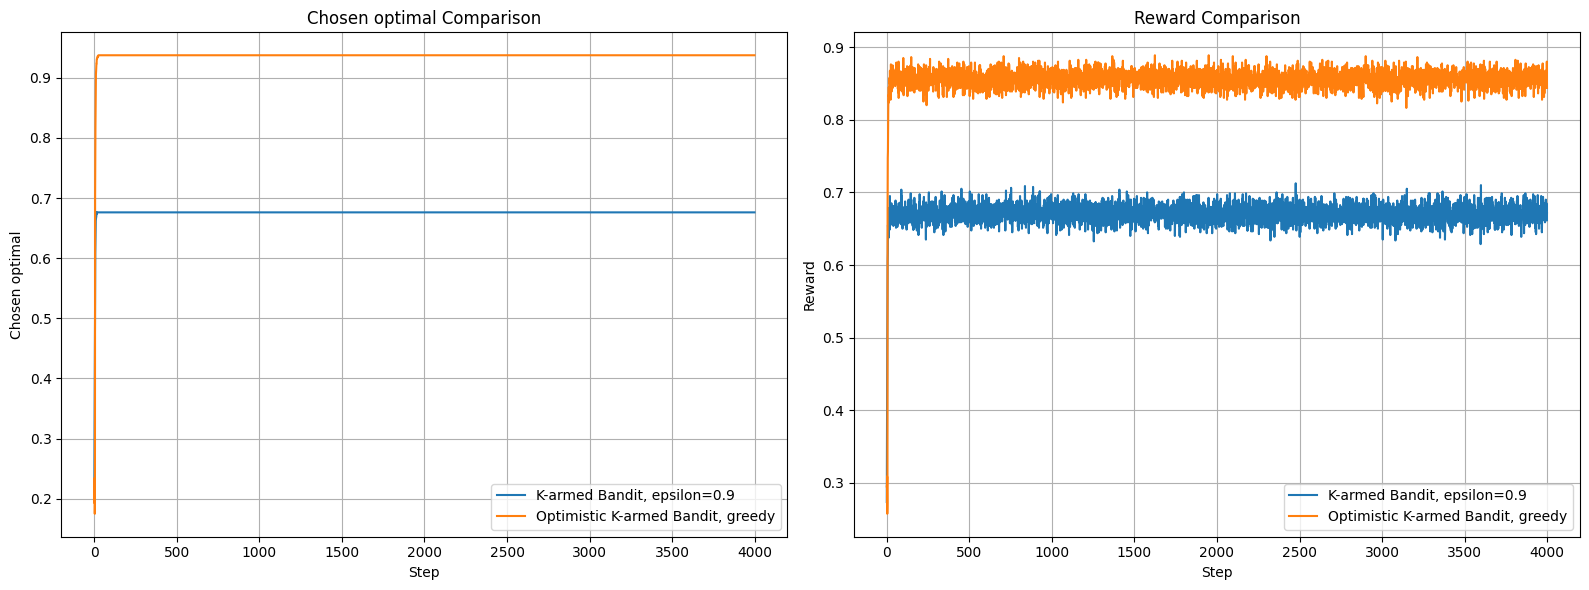

In [24]:
figsize = (16, 6)

model1, model2 = "mab", "mab"

column1 = 'chosen_optimal'
ylabel1 = getlabel(column1)
argmax1_col1, label1_col1 = summary(mab_bern_half, model1, column1, greedy=False, is_optimistic=False)
argmax2_col1, label2_col1 = summary(mab_opt_bern_half, model2, column1, greedy=True, is_optimistic=True)

column2 = 'reward'
ylabel2 = getlabel(column2)
argmax1_col2, label1_col2 = summary(mab_bern_half, model1, column2, greedy=False, is_optimistic=False)
argmax2_col2, label2_col2 = summary(mab_opt_bern_half, model2, column2, greedy=True, is_optimistic=True)

plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(mab_bern_half[argmax1_col1][column1], label=label1_col1)
plt.plot(mab_opt_bern_half[argmax2_col1][column1], label=label2_col1)
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(ylabel1)
plt.legend()
plt.title(f"{ylabel1} Comparison")

plt.subplot(122)
plt.plot(mab_bern_half[argmax1_col2][column2], label=label1_col2)
plt.plot(mab_opt_bern_half[argmax2_col2][column2], label=label2_col2)
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(ylabel2)
plt.legend()
plt.title(f"{ylabel2} Comparison")

plt.tight_layout()
plt.show()

### Gaussian $\alpha$=1

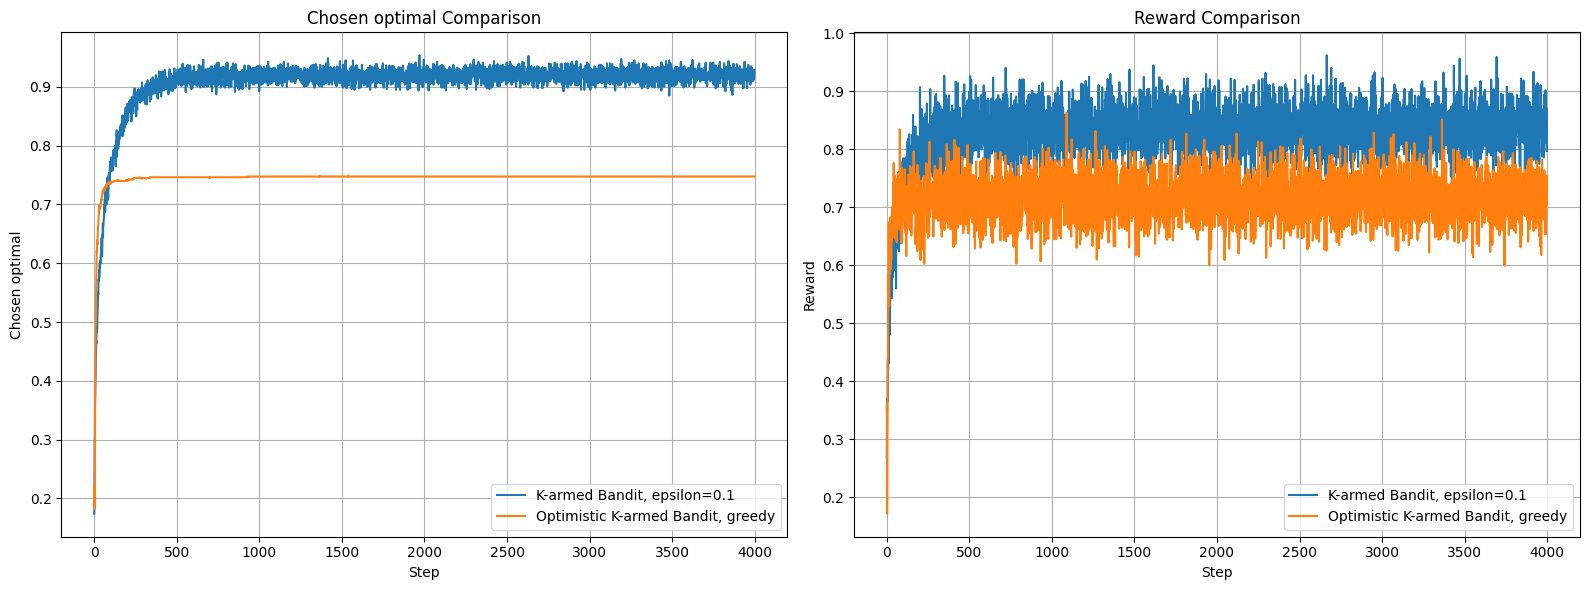

In [25]:
figsize = (16, 6)

model1, model2 = "mab", "mab"

column1 = 'chosen_optimal'
ylabel1 = getlabel(column1)
argmax1_col1, label1_col1 = summary(mab_gaus_1, model1, column1, greedy=False, is_optimistic=False)
argmax2_col1, label2_col1 = summary(mab_opt_gaus_1, model2, column1, greedy=True, is_optimistic=True)

column2 = 'reward'
ylabel2 = getlabel(column2)
argmax1_col2, label1_col2 = summary(mab_gaus_1, model1, column2, greedy=False, is_optimistic=False)
argmax2_col2, label2_col2 = summary(mab_opt_gaus_1, model2, column2, greedy=True, is_optimistic=True)

plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(mab_gaus_1[argmax1_col1][column1], label=label1_col1)
plt.plot(mab_opt_gaus_1[argmax2_col1][column1], label=label2_col1)
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(ylabel1)
plt.legend()
plt.title(f"{ylabel1} Comparison")

plt.subplot(122)
plt.plot(mab_gaus_1[argmax1_col2][column2], label=label1_col2)
plt.plot(mab_opt_gaus_1[argmax2_col2][column2], label=label2_col2)
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(ylabel2)
plt.legend()
plt.title(f"{ylabel2} Comparison")

plt.tight_layout()
plt.show()

### Gaussian $\alpha$=0.5

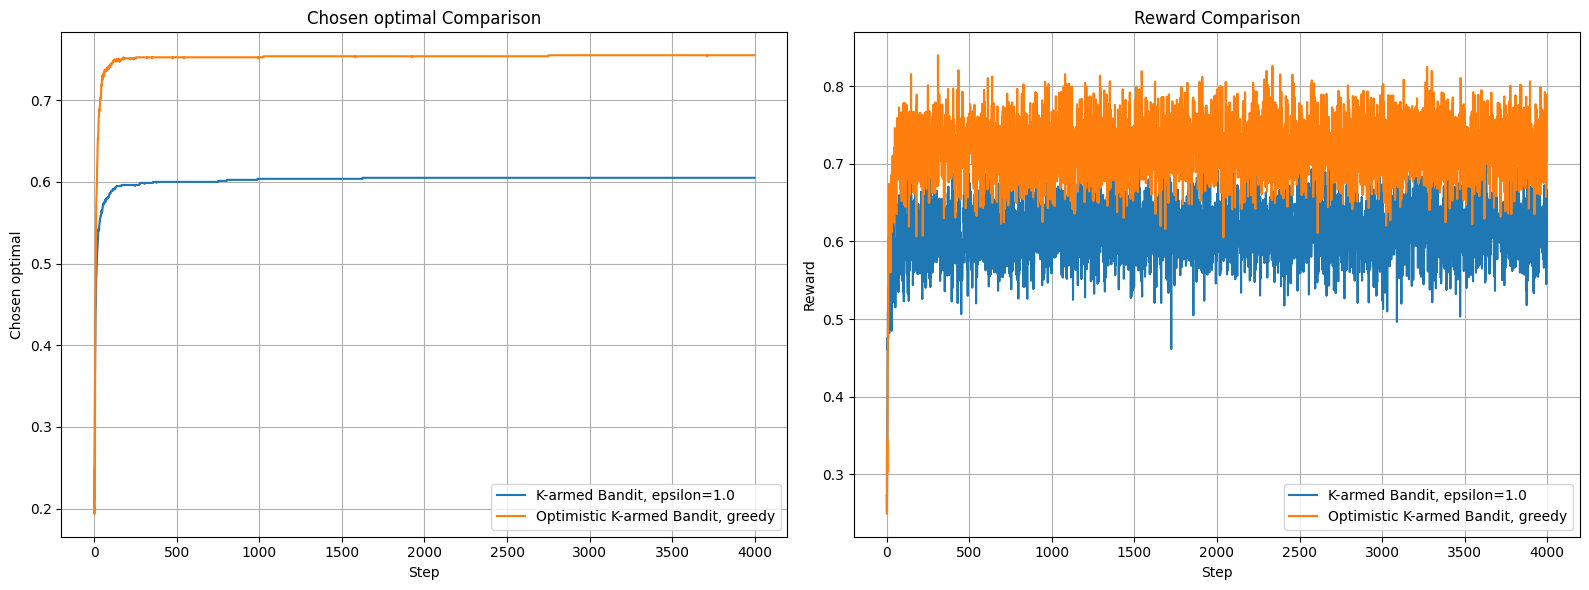

In [26]:
figsize = (16, 6)

model1, model2 = "mab", "mab"

column1 = 'chosen_optimal'
ylabel1 = getlabel(column1)
argmax1_col1, label1_col1 = summary(mab_gaus_half, model1, column1, greedy=False, is_optimistic=False)
argmax2_col1, label2_col1 = summary(mab_opt_gaus_half, model2, column1, greedy=True, is_optimistic=True)

column2 = 'reward'
ylabel2 = getlabel(column2)
argmax1_col2, label1_col2 = summary(mab_gaus_half, model1, column2, greedy=False, is_optimistic=False)
argmax2_col2, label2_col2 = summary(mab_opt_gaus_half, model2, column2, greedy=True, is_optimistic=True)

plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(mab_gaus_half[argmax1_col1][column1], label=label1_col1)
plt.plot(mab_opt_gaus_half[argmax2_col1][column1], label=label2_col1)
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(ylabel1)
plt.legend()
plt.title(f"{ylabel1} Comparison")

plt.subplot(122)
plt.plot(mab_gaus_half[argmax1_col2][column2], label=label1_col2)
plt.plot(mab_opt_gaus_half[argmax2_col2][column2], label=label2_col2)
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(ylabel2)
plt.legend()
plt.title(f"{ylabel2} Comparison")

plt.tight_layout()
plt.show()

# Explore-then-Commit

In [27]:
etc_bern_1 = procedure(fname="./ETC_BernoulliArm_1.0_Naive_results.pkl", no_param=False)
etc_gaus_1 = procedure(fname="./ETC_GaussianArm_1.0_Naive_results.pkl", no_param=False)

100%|██████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.07s/it]


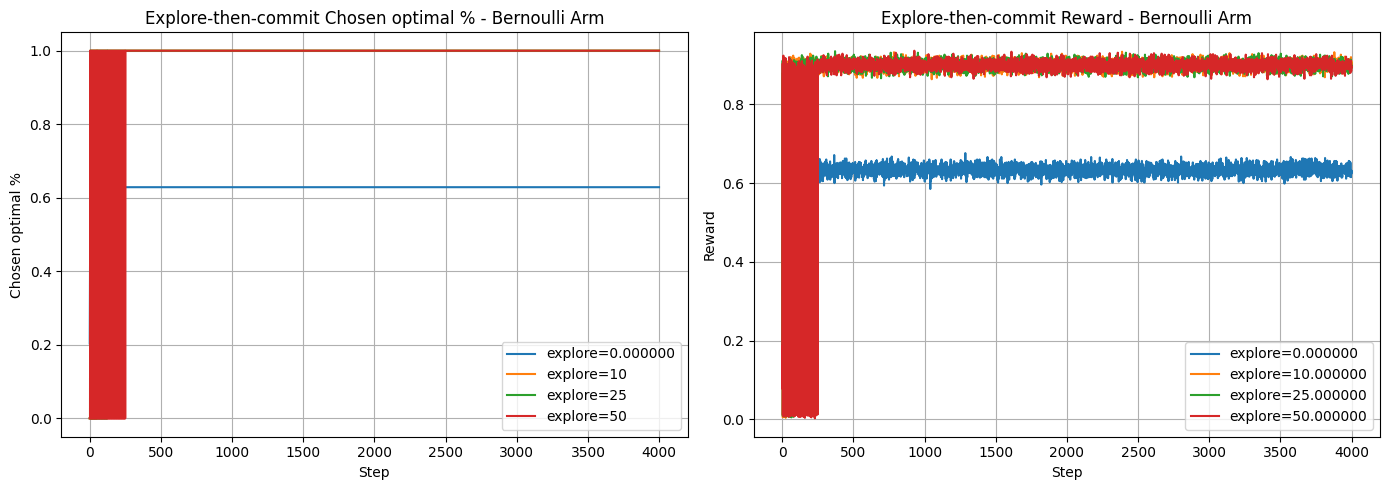

In [28]:
plot_results(etc_bern_1, arm="Bernoulli", model="etc")

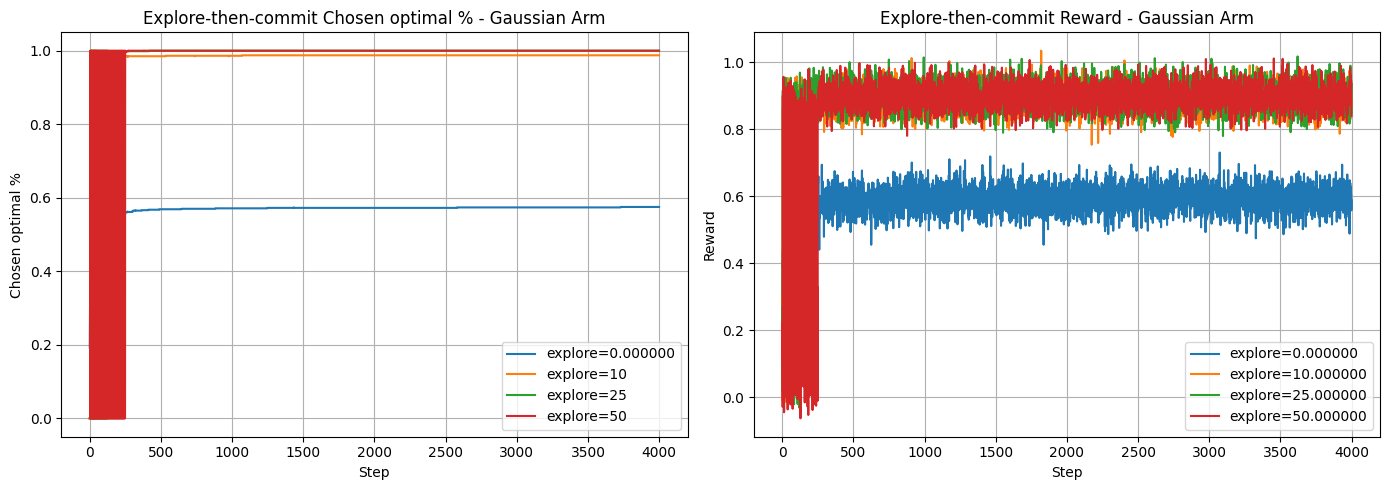

In [29]:
plot_results(etc_gaus_1, arm="Gaussian", model="etc")

# Thompson Sampling

In [30]:
ts_bern = procedure(fname="./ThompsonSampling_BernoulliArm_1.0_Naive_results.pkl", no_param=True)
ts_gaus = procedure(fname="./ThompsonSampling_GaussianArm_1.0_Naive_results.pkl", no_param=True)

100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.04s/it]


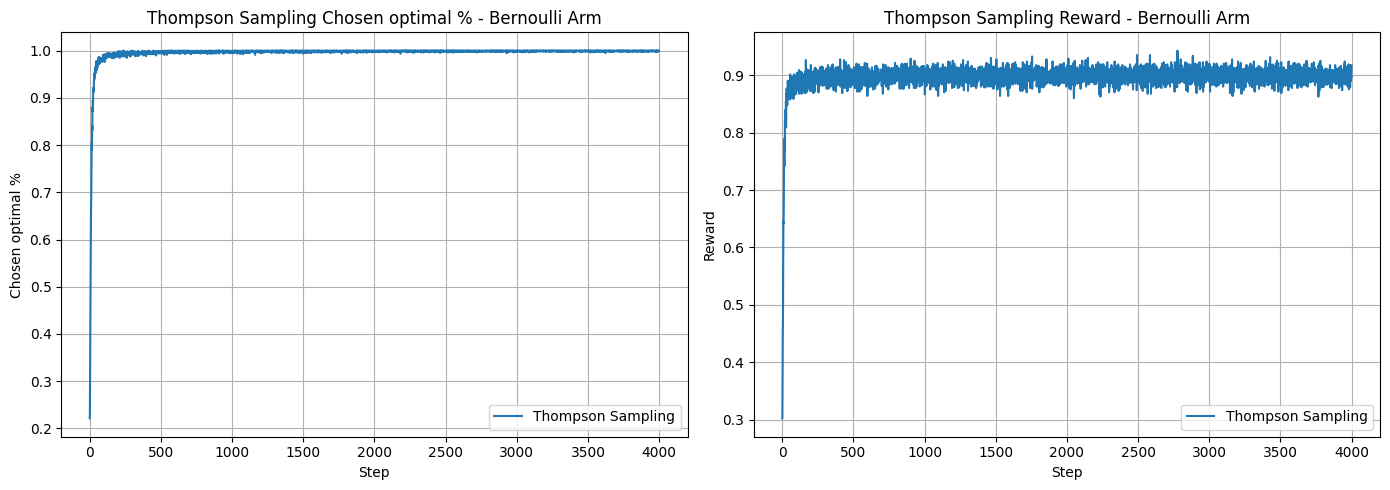

In [31]:
plot_results(ts_bern, arm="Bernoulli", model="thompson")

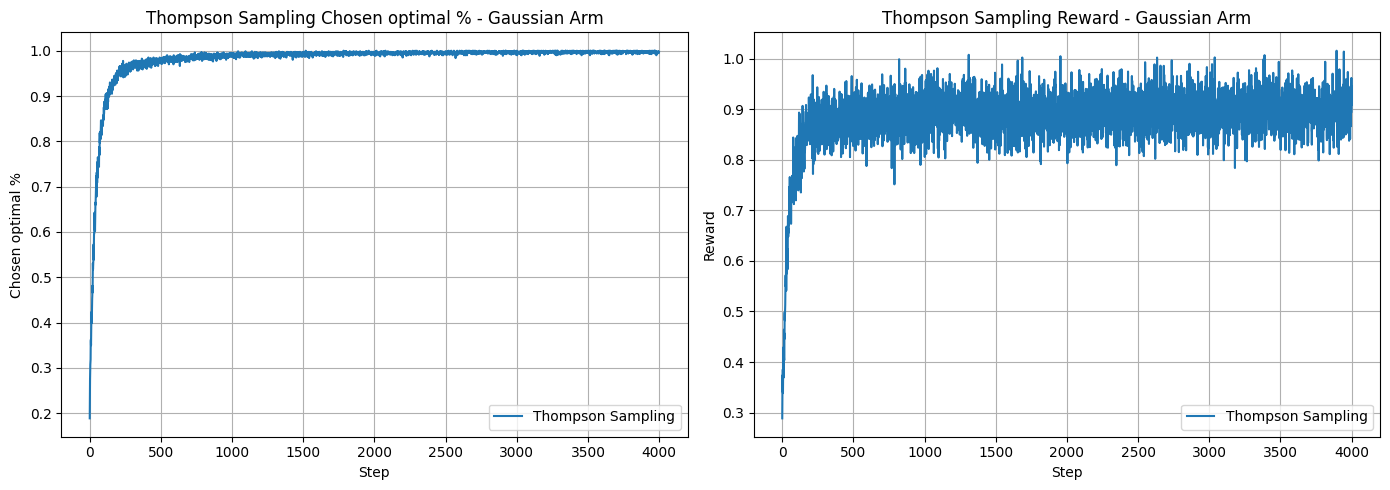

In [32]:
plot_results(ts_gaus, arm="Gaussian", model="thompson")

# UCB

## Naive

In [33]:
ucbnaive_bern_1 = procedure(fname="./UCBNaive_BernoulliArm_1.0_Naive_results.pkl", no_param=False)
ucbnaive_gaus_1 = procedure(fname="./UCBNaive_GaussianArm_1.0_Naive_results.pkl", no_param=False)

100%|██████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.12s/it]


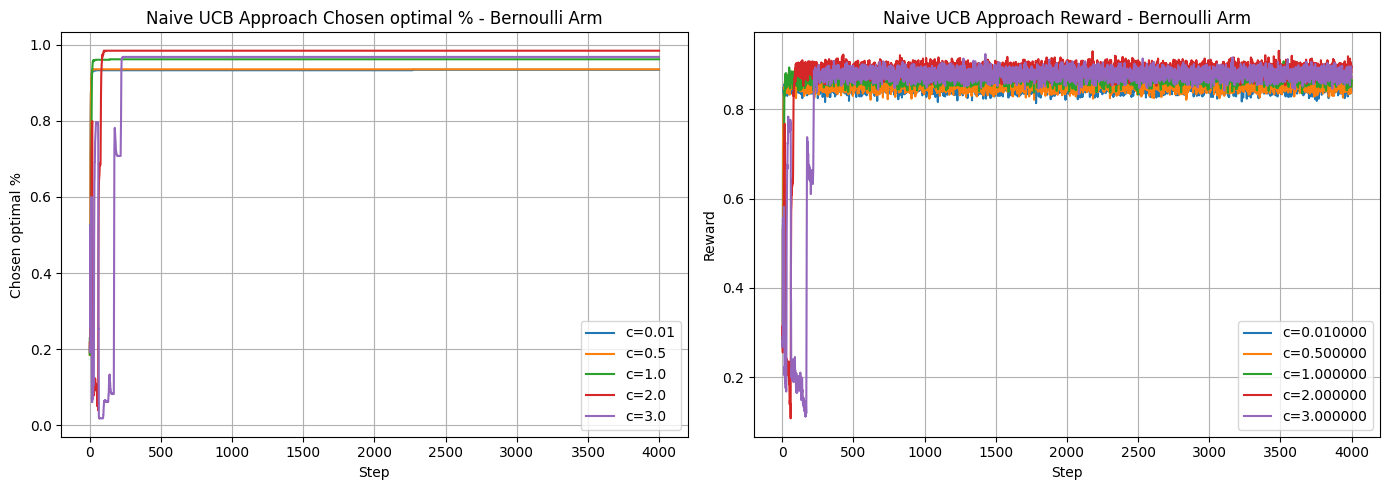

In [34]:
plot_results(ucbnaive_bern_1, arm="Bernoulli", model="ucbnaive")

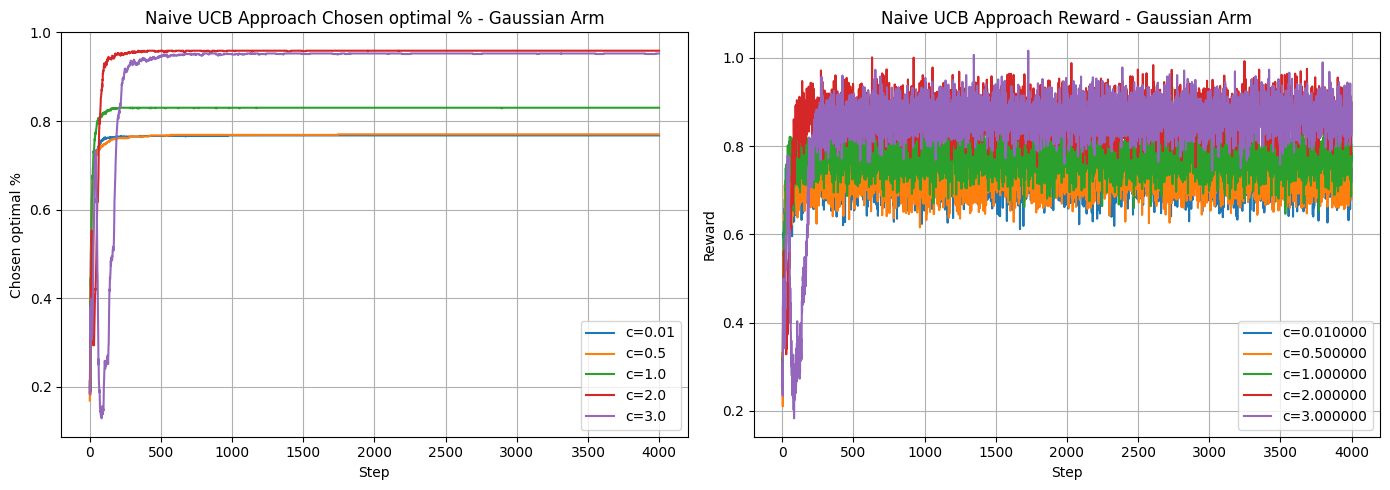

In [35]:
plot_results(ucbnaive_gaus_1, arm="Gaussian", model="ucbnaive")

## Delta

In [36]:
ucbdelta_bern_1 = procedure(fname="./UCBDelta_BernoulliArm_1.0_Naive_results.pkl", no_param=False)
ucbdelta_gaus_1 = procedure(fname="./UCBDelta_GaussianArm_1.0_Naive_results.pkl", no_param=False)

100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.13s/it]


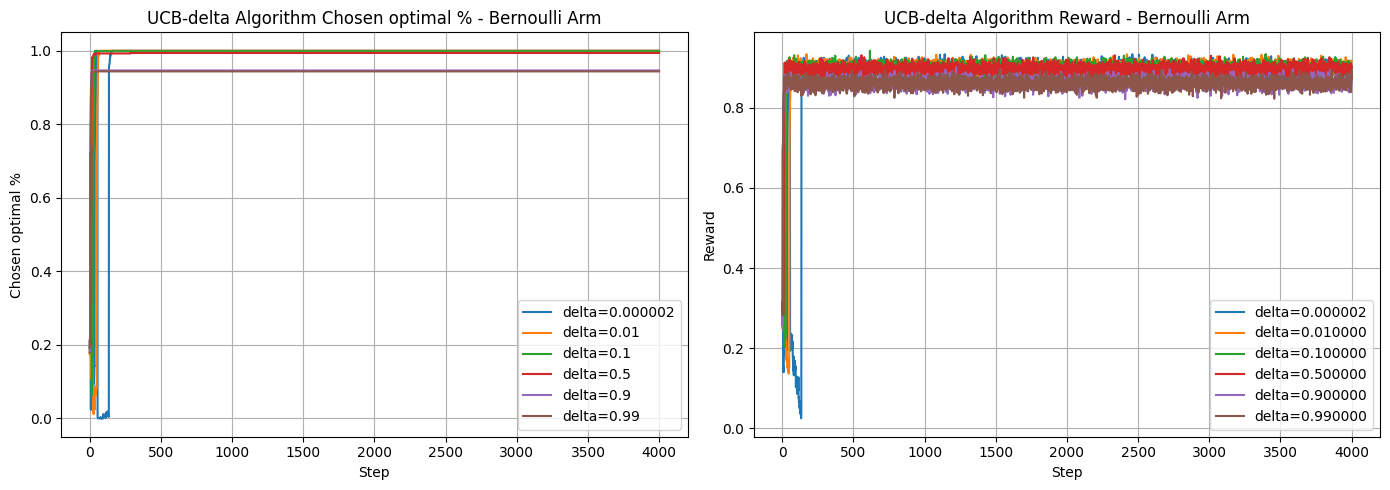

In [37]:
plot_results(ucbdelta_bern_1, arm="Bernoulli", model="ucbdelta")

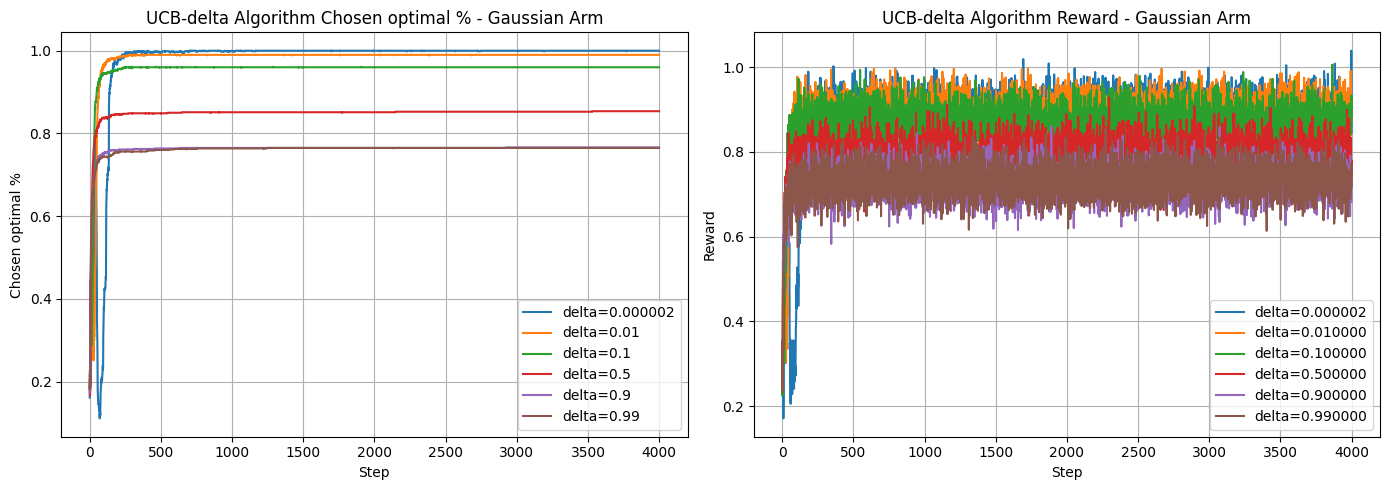

In [38]:
plot_results(ucbdelta_gaus_1, arm="Gaussian", model="ucbdelta")

## Asymptotically Optimal

In [39]:
ucbasym_bern_1 = procedure(fname="./UCBAsymptotic_BernoulliArm_1.0_Naive_results.pkl", no_param=True)
ucbasym_gaus_1 = procedure(fname="./UCBAsymptotic_GaussianArm_1.0_Naive_results.pkl", no_param=True)

100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.94s/it]


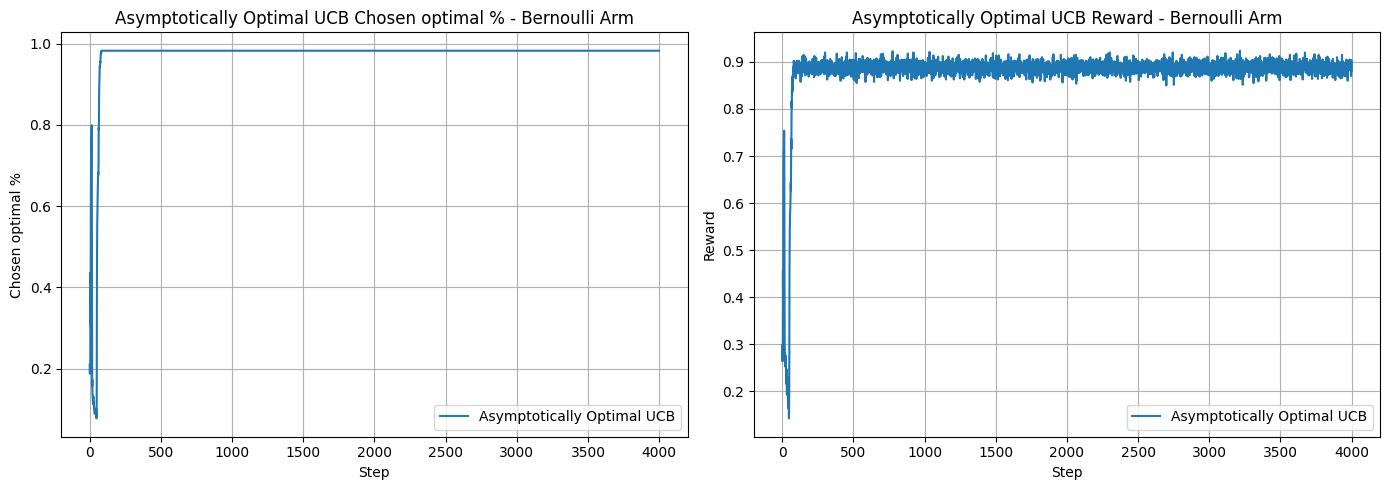

In [40]:
plot_results(ucbasym_bern_1, arm="Bernoulli", model="ucbasym")

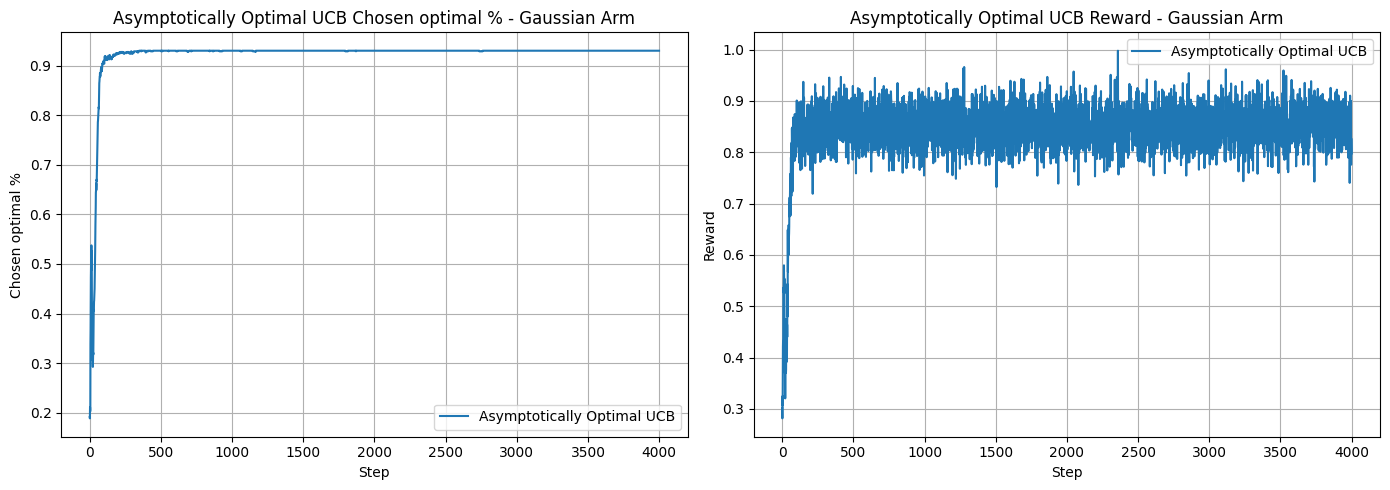

In [41]:
plot_results(ucbasym_gaus_1, arm="Gaussian", model="ucbasym")

## MOSS

In [42]:
ucbmoss_bern_1 = procedure(fname="./UCBMOSS_BernoulliArm_1.0_Naive_results.pkl", no_param=True)
ucbmoss_gaus_1 = procedure(fname="./UCBMOSS_GaussianArm_1.0_Naive_results.pkl", no_param=True)

100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.12s/it]


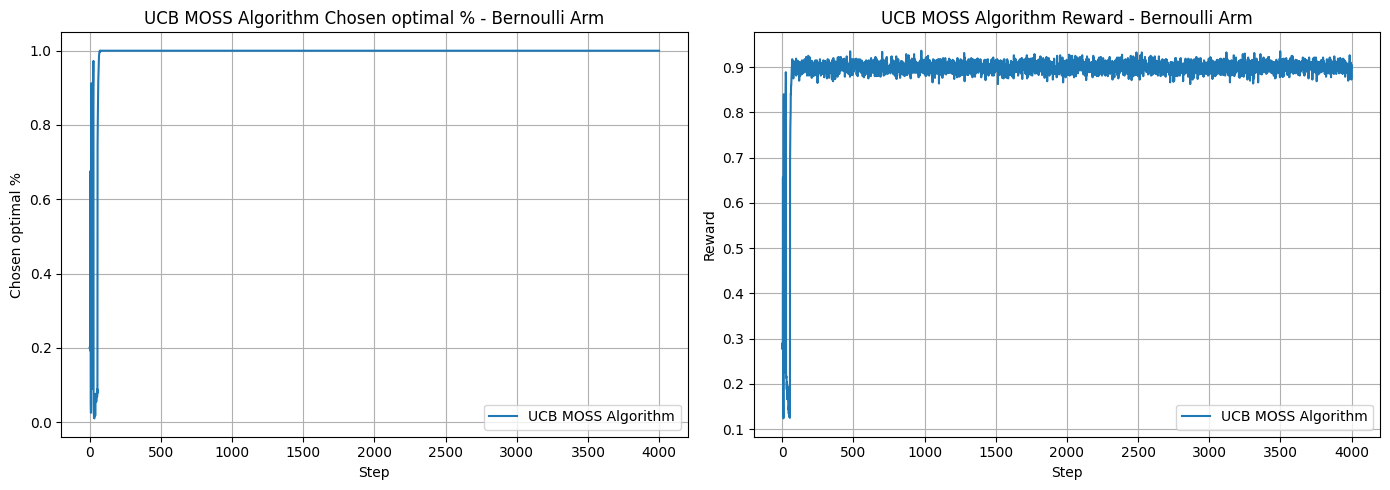

In [43]:
plot_results(ucbmoss_bern_1, arm="Bernoulli", model="ucbmoss")

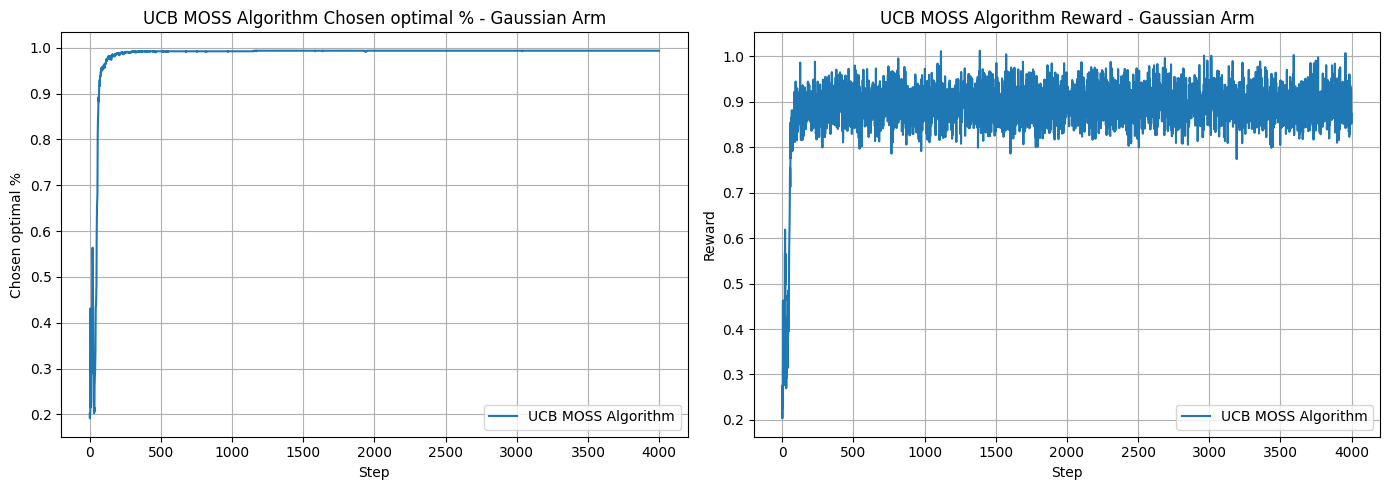

In [44]:
plot_results(ucbmoss_gaus_1, arm="Gaussian", model="ucbmoss")

## UCB Comparison

### Bernoulli Arm

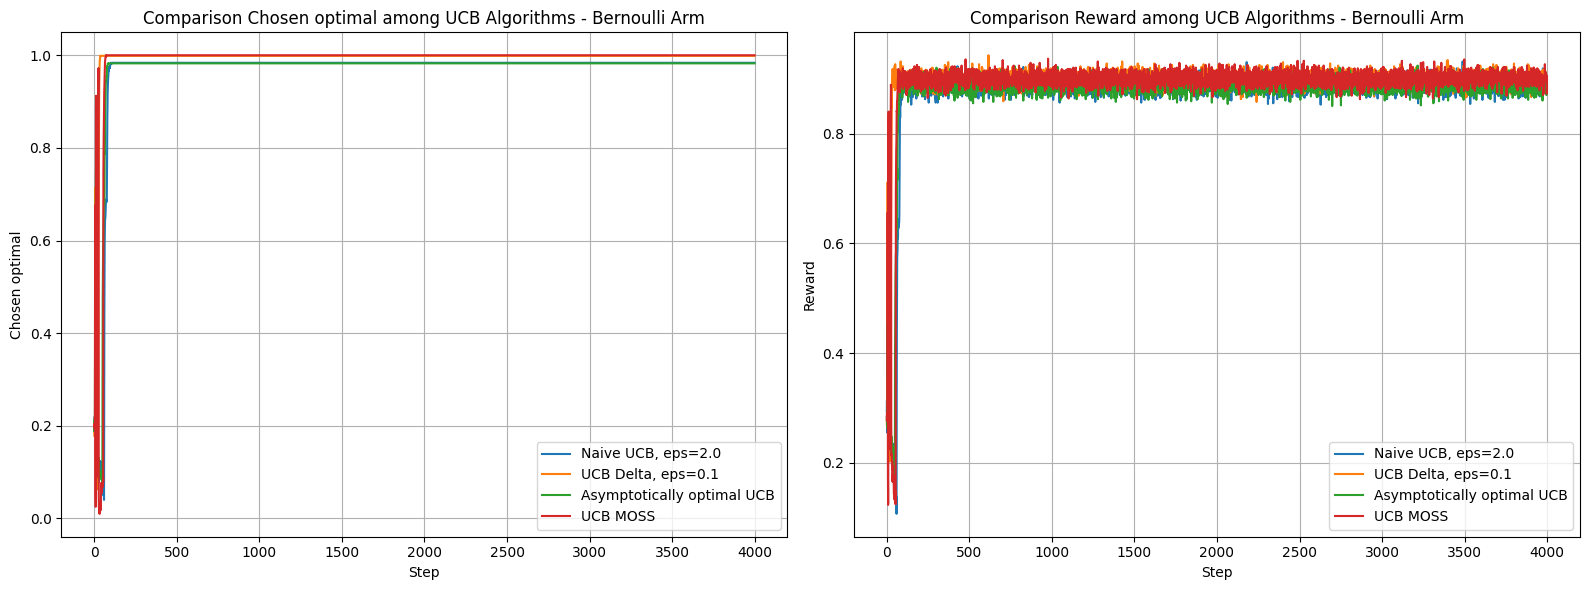

In [45]:
optimal = 'chosen_optimal'
reward = 'reward'

## find the best confidence term - naive approach
naive_mean_choices = [item[optimal].mean() for item in ucbnaive_bern_1]
naive_argmax = np.argmax(naive_mean_choices)

## find the best delta
delta_mean_choices = [item[optimal].mean() for item in ucbdelta_bern_1]
delta_argmax = np.argmax(delta_mean_choices)

naive_best_epsilon = ucbnaive_bern_1[naive_argmax]['param'].iloc[0]
delta_best_epsilon = ucbdelta_bern_1[delta_argmax]['param'].iloc[0]

figsize=(16, 6)
optimal_label = getlabel(optimal)
reward_label = getlabel(reward)

plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(ucbnaive_bern_1[naive_argmax][optimal], label=f"Naive UCB, eps={naive_best_epsilon}")
plt.plot(ucbdelta_bern_1[delta_argmax][optimal], label=f"UCB Delta, eps={delta_best_epsilon}")
plt.plot(ucbasym_bern_1[0][optimal], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_bern_1[0][optimal], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(optimal_label)
plt.legend()
plt.title(f"Comparison {optimal_label} among UCB Algorithms - Bernoulli Arm")

plt.subplot(122)
plt.plot(ucbnaive_bern_1[naive_argmax][reward], label=f"Naive UCB, eps={naive_best_epsilon}")
plt.plot(ucbdelta_bern_1[delta_argmax][reward], label=f"UCB Delta, eps={delta_best_epsilon}")
plt.plot(ucbasym_bern_1[0][reward], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_bern_1[0][reward], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(reward_label)
plt.legend()
plt.title(f"Comparison {reward_label} among UCB Algorithms - Bernoulli Arm")

plt.tight_layout()
plt.show()

### Gaussian Arm

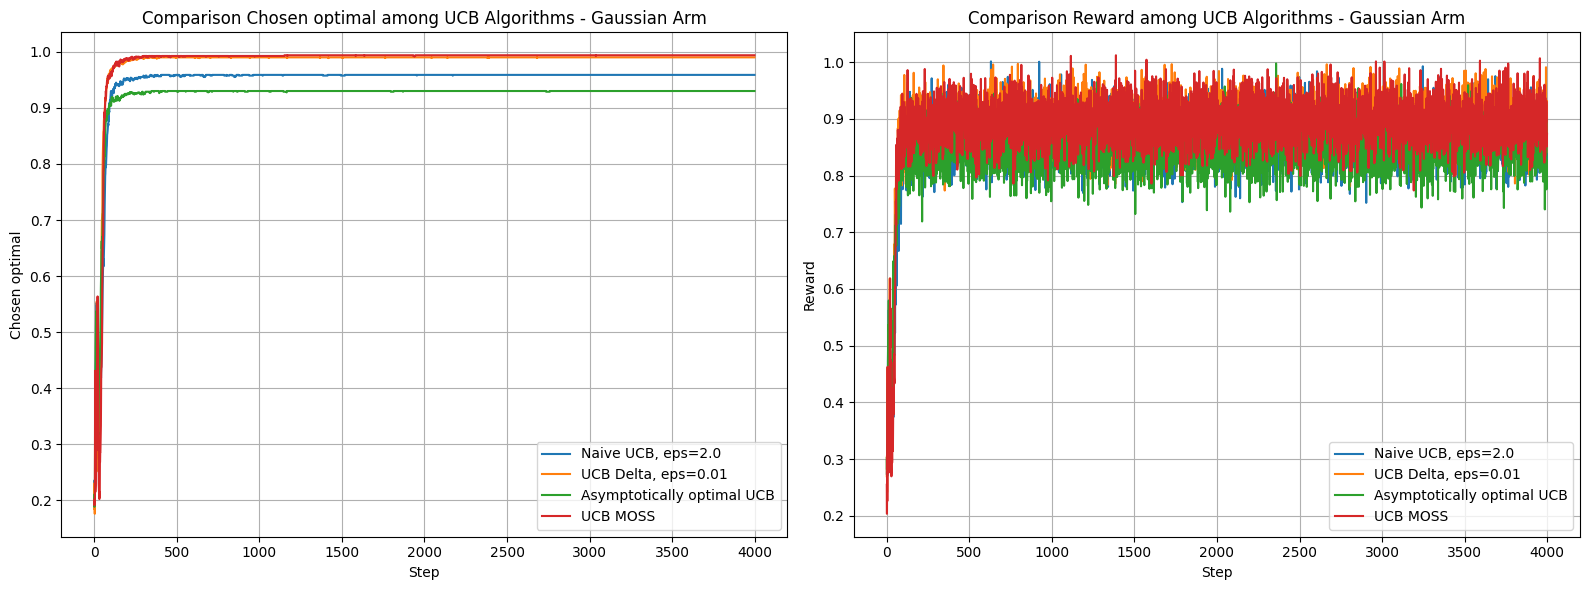

In [46]:
optimal = 'chosen_optimal'
reward = 'reward'

## find the best confidence term - naive approach
naive_mean_choices = [item[optimal].mean() for item in ucbnaive_gaus_1]
naive_argmax = np.argmax(naive_mean_choices)

## find the best delta
delta_mean_choices = [item[optimal].mean() for item in ucbdelta_gaus_1]
delta_argmax = np.argmax(delta_mean_choices)

naive_best_epsilon = ucbnaive_gaus_1[naive_argmax]['param'].iloc[0]
delta_best_epsilon = ucbdelta_gaus_1[delta_argmax]['param'].iloc[0]

figsize=(16, 6)
optimal_label = getlabel(optimal)
reward_label = getlabel(reward)

plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(ucbnaive_gaus_1[naive_argmax][optimal], label=f"Naive UCB, eps={naive_best_epsilon}")
plt.plot(ucbdelta_gaus_1[delta_argmax][optimal], label=f"UCB Delta, eps={delta_best_epsilon}")
plt.plot(ucbasym_gaus_1[0][optimal], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_gaus_1[0][optimal], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(optimal_label)
plt.legend()
plt.title(f"Comparison {optimal_label} among UCB Algorithms - Gaussian Arm")

plt.subplot(122)
plt.plot(ucbnaive_gaus_1[naive_argmax][reward], label=f"Naive UCB, eps={naive_best_epsilon}")
plt.plot(ucbdelta_gaus_1[delta_argmax][reward], label=f"UCB Delta, eps={delta_best_epsilon}")
plt.plot(ucbasym_gaus_1[0][reward], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_gaus_1[0][reward], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(reward_label)
plt.legend()
plt.title(f"Comparison {reward_label} among UCB Algorithms - Gaussian Arm")

plt.tight_layout()
plt.show()

# Comparison

## Bernoulli Arm

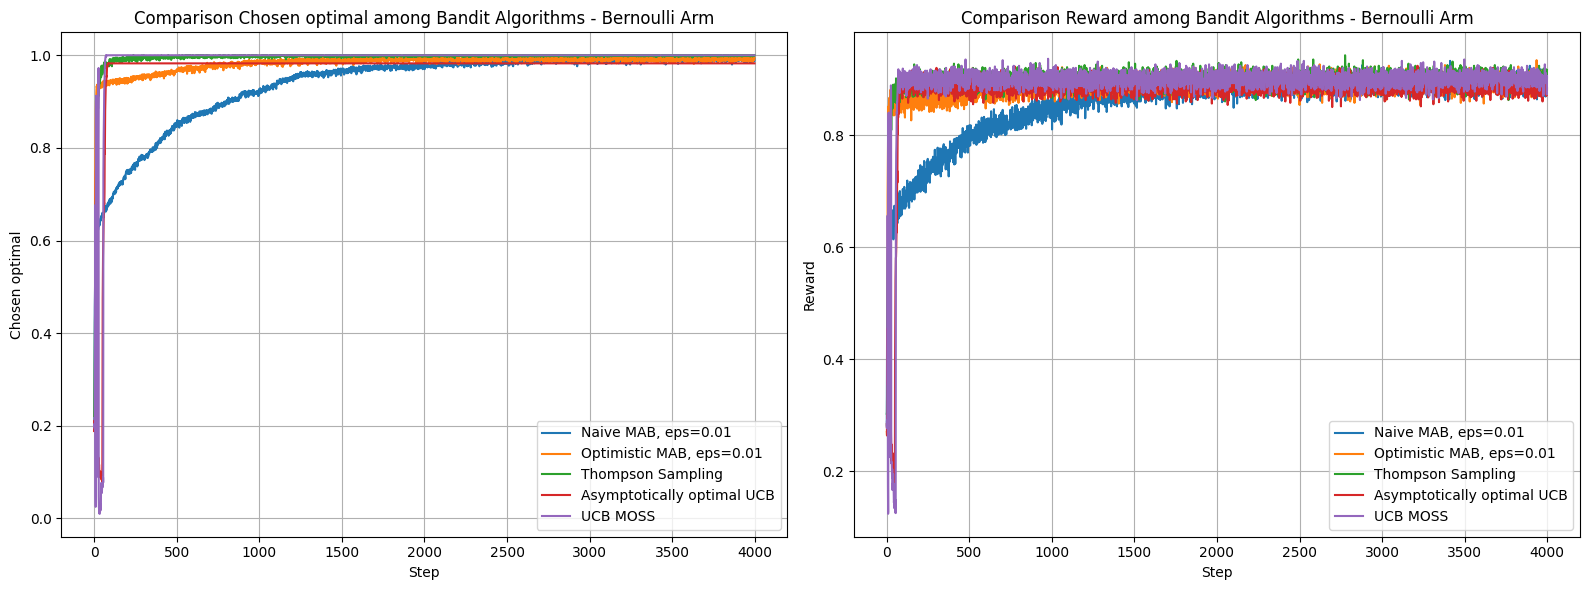

In [47]:
optimal = 'chosen_optimal'
reward = 'reward'

## find the best epsilon - naive approach
naive_mean_choices = [item[optimal].mean() for item in mab_bern_1]
naive_argmax = np.argmax(naive_mean_choices)

## find the best epsilon - optimistic approach
opt_mean_choices = [item[optimal].mean() for item in mab_opt_bern_1]
opt_argmax = np.argmax(opt_mean_choices)

naive_best_epsilon = mab_bern_1[naive_argmax]['param'].iloc[0]
opt_best_epsilon = mab_opt_bern_1[opt_argmax]['param'].iloc[0]

figsize=(16, 6)
optimal_label = getlabel(optimal)
reward_label = getlabel(reward)

plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(mab_bern_1[naive_argmax][optimal], label=f"Naive MAB, eps={naive_best_epsilon}")
plt.plot(mab_opt_bern_1[opt_argmax][optimal], label=f"Optimistic MAB, eps={opt_best_epsilon}")
plt.plot(ts_bern[0][optimal], label=f"Thompson Sampling")
plt.plot(ucbasym_bern_1[0][optimal], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_bern_1[0][optimal], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(optimal_label)
plt.legend()
plt.title(f"Comparison {optimal_label} among Bandit Algorithms - Bernoulli Arm")

plt.subplot(122)
plt.plot(mab_bern_1[naive_argmax][reward], label=f"Naive MAB, eps={naive_best_epsilon}")
plt.plot(mab_opt_bern_1[opt_argmax][reward], label=f"Optimistic MAB, eps={opt_best_epsilon}")
plt.plot(ts_bern[0][reward], label=f"Thompson Sampling")
plt.plot(ucbasym_bern_1[0][reward], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_bern_1[0][reward], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(reward_label)
plt.legend()
plt.title(f"Comparison {reward_label} among Bandit Algorithms - Bernoulli Arm")

plt.tight_layout()
plt.show()

## Gaussian Arm

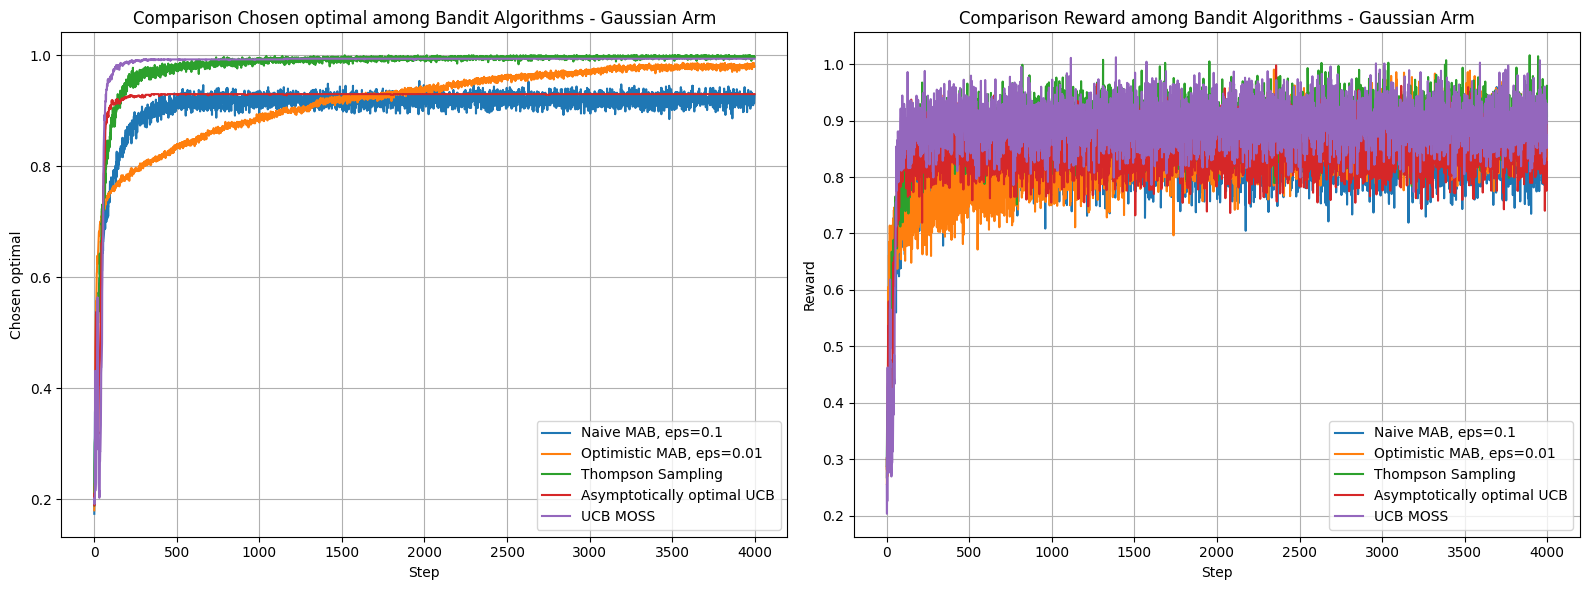

In [48]:
optimal = 'chosen_optimal'
reward = 'reward'

## find the best epsilon - naive approach
naive_mean_choices = [item[optimal].mean() for item in mab_gaus_1]
naive_argmax = np.argmax(naive_mean_choices)

## find the best epsilon - optimistic approach
opt_mean_choices = [item[optimal].mean() for item in mab_opt_gaus_1]
opt_argmax = np.argmax(opt_mean_choices)

naive_best_epsilon = mab_gaus_1[naive_argmax]['param'].iloc[0]
opt_best_epsilon = mab_opt_gaus_1[opt_argmax]['param'].iloc[0]

figsize=(16, 6)
optimal_label = getlabel(optimal)
reward_label = getlabel(reward)

plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(mab_gaus_1[naive_argmax][optimal], label=f"Naive MAB, eps={naive_best_epsilon}")
plt.plot(mab_opt_gaus_1[opt_argmax][optimal], label=f"Optimistic MAB, eps={opt_best_epsilon}")
plt.plot(ts_gaus[0][optimal], label=f"Thompson Sampling")
plt.plot(ucbasym_gaus_1[0][optimal], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_gaus_1[0][optimal], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(optimal_label)
plt.legend()
plt.title(f"Comparison {optimal_label} among Bandit Algorithms - Gaussian Arm")

plt.subplot(122)
plt.plot(mab_gaus_1[naive_argmax][reward], label=f"Naive MAB, eps={naive_best_epsilon}")
plt.plot(mab_opt_gaus_1[opt_argmax][reward], label=f"Optimistic MAB, eps={opt_best_epsilon}")
plt.plot(ts_gaus[0][reward], label=f"Thompson Sampling")
plt.plot(ucbasym_gaus_1[0][reward], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_gaus_1[0][reward], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(reward_label)
plt.legend()
plt.title(f"Comparison {reward_label} among Bandit Algorithms - Gaussian Arm")

plt.tight_layout()
plt.show()

# Ambiguous Case

In [49]:
os.chdir("../indefinite")
!ls

eGreedyMAB_BernoulliArm_0.5_Naive_results.pkl
eGreedyMAB_BernoulliArm_0.5_Optimistic_results.pkl
eGreedyMAB_BernoulliArm_1.0_Naive_results.pkl
eGreedyMAB_BernoulliArm_1.0_Optimistic_results.pkl
eGreedyMAB_GaussianArm_0.5_Naive_results.pkl
eGreedyMAB_GaussianArm_0.5_Optimistic_results.pkl
eGreedyMAB_GaussianArm_1.0_Naive_results.pkl
eGreedyMAB_GaussianArm_1.0_Optimistic_results.pkl
ETC_BernoulliArm_1.0_Naive_results.pkl
ETC_GaussianArm_1.0_Naive_results.pkl
ThompsonSampling_BernoulliArm_1.0_Naive_results.pkl
ThompsonSampling_GaussianArm_1.0_Naive_results.pkl
UCBAsymptotic_BernoulliArm_1.0_Naive_results.pkl
UCBAsymptotic_GaussianArm_1.0_Naive_results.pkl
UCBDelta_BernoulliArm_1.0_Naive_results.pkl
UCBDelta_GaussianArm_1.0_Naive_results.pkl
UCBMOSS_BernoulliArm_1.0_Naive_results.pkl
UCBMOSS_GaussianArm_1.0_Naive_results.pkl
UCBNaive_BernoulliArm_1.0_Naive_results.pkl
UCBNaive_GaussianArm_1.0_Naive_results.pkl


## Naive Multi-Armed Bandit

### $\alpha$=1

In [50]:
mab_bern_1 = procedure(fname="./eGreedyMAB_BernoulliArm_1.0_Naive_results.pkl", no_param=False)
mab_gaus_1 = procedure(fname="./eGreedyMAB_GaussianArm_1.0_Naive_results.pkl", no_param=False)

100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.08s/it]


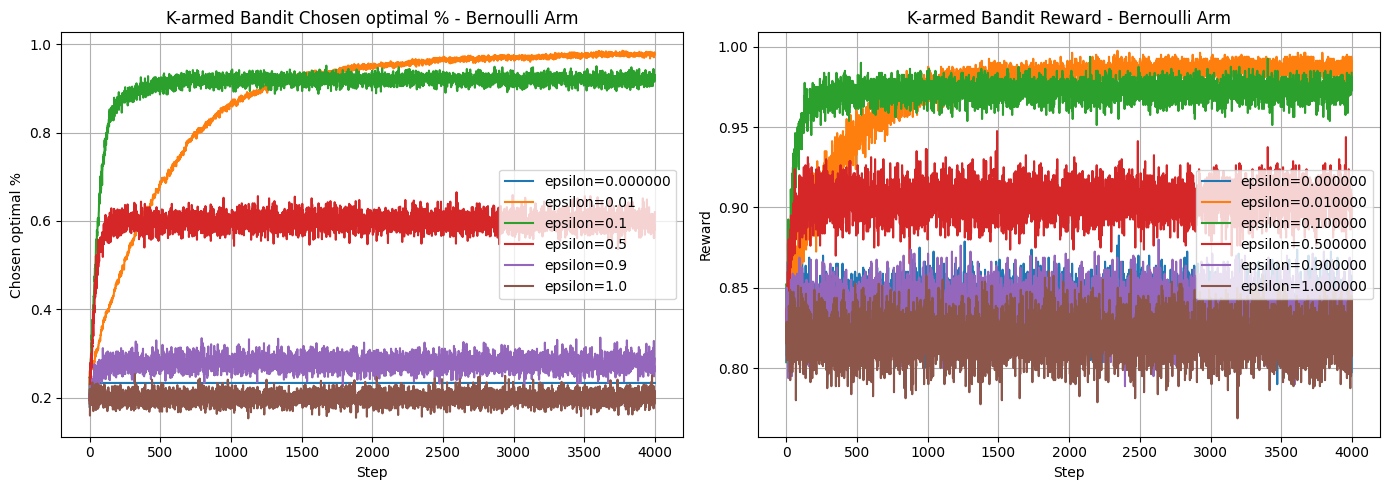

In [51]:
plot_results(mab_bern_1, arm="Bernoulli", model="mab")

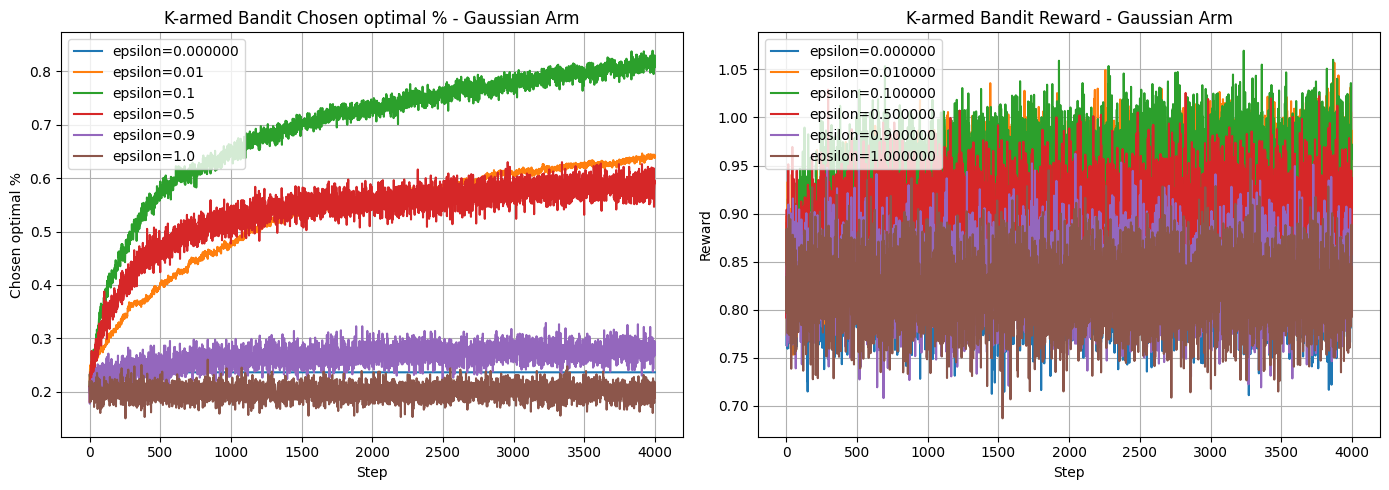

In [52]:
plot_results(mab_gaus_1, arm="Gaussian", model="mab")

### $\alpha$=0.5

In [53]:
mab_bern_half = procedure(fname="./eGreedyMAB_BernoulliArm_0.5_Naive_results.pkl", no_param=False)
mab_gaus_half = procedure(fname="./eGreedyMAB_GaussianArm_0.5_Naive_results.pkl", no_param=False)

100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:32<00:00,  5.37s/it]


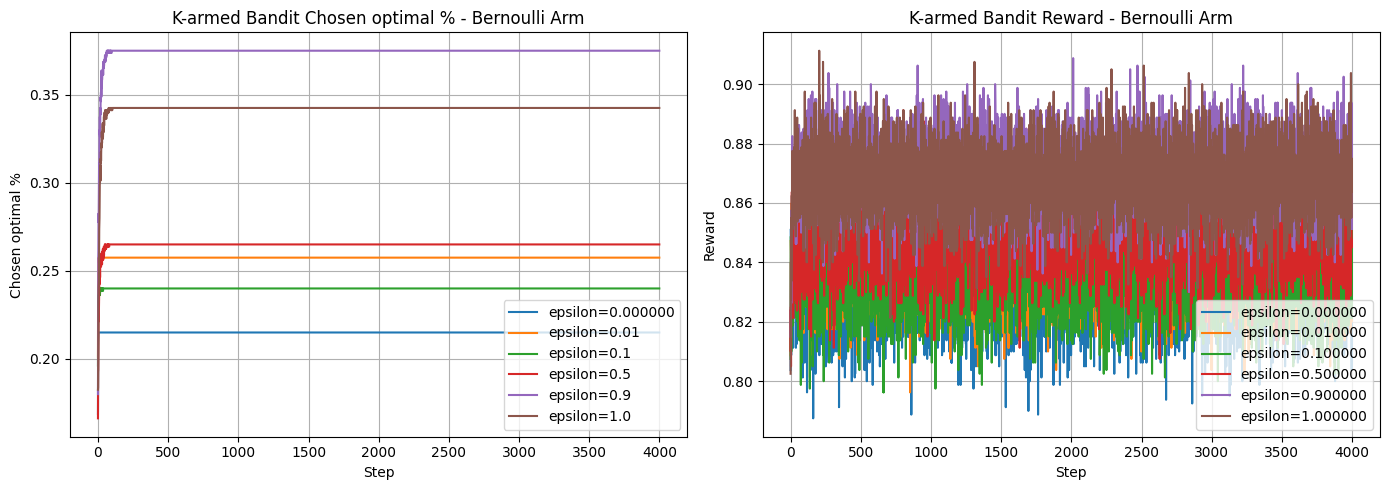

In [54]:
plot_results(mab_bern_half, arm="Bernoulli", model="mab")

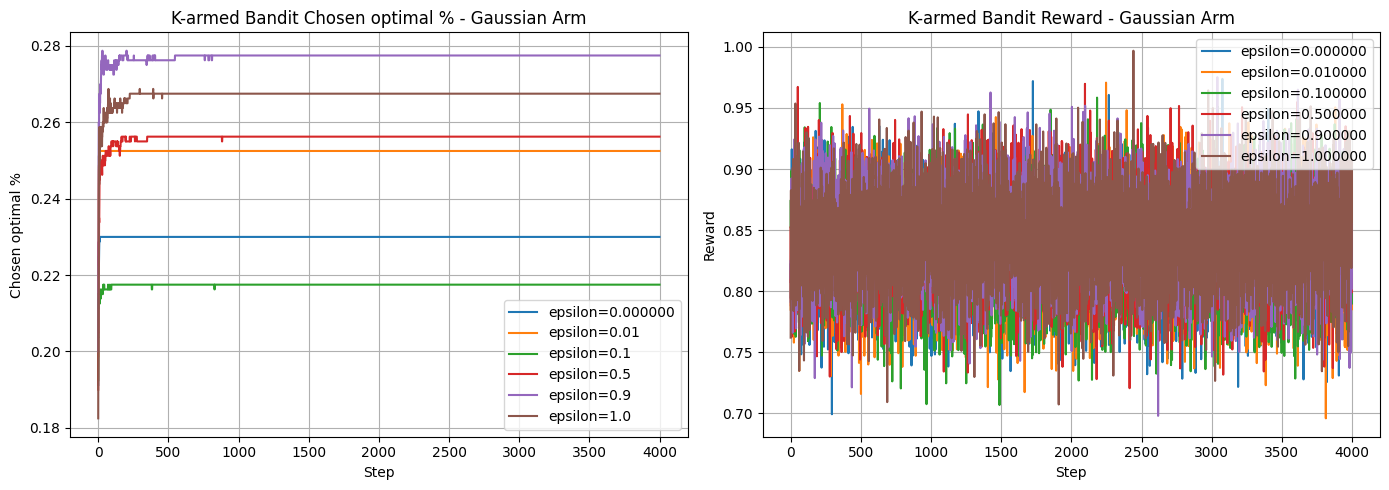

In [55]:
plot_results(mab_gaus_half, arm="Gaussian", model="mab")

## Optimistic Multi-Armed Bandit

### $\alpha$=1

In [56]:
mab_opt_bern_1 = procedure(fname="./eGreedyMAB_BernoulliArm_1.0_Optimistic_results.pkl", no_param=False)
mab_opt_gaus_1 = procedure(fname="./eGreedyMAB_GaussianArm_1.0_Optimistic_results.pkl", no_param=False)

100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.16s/it]


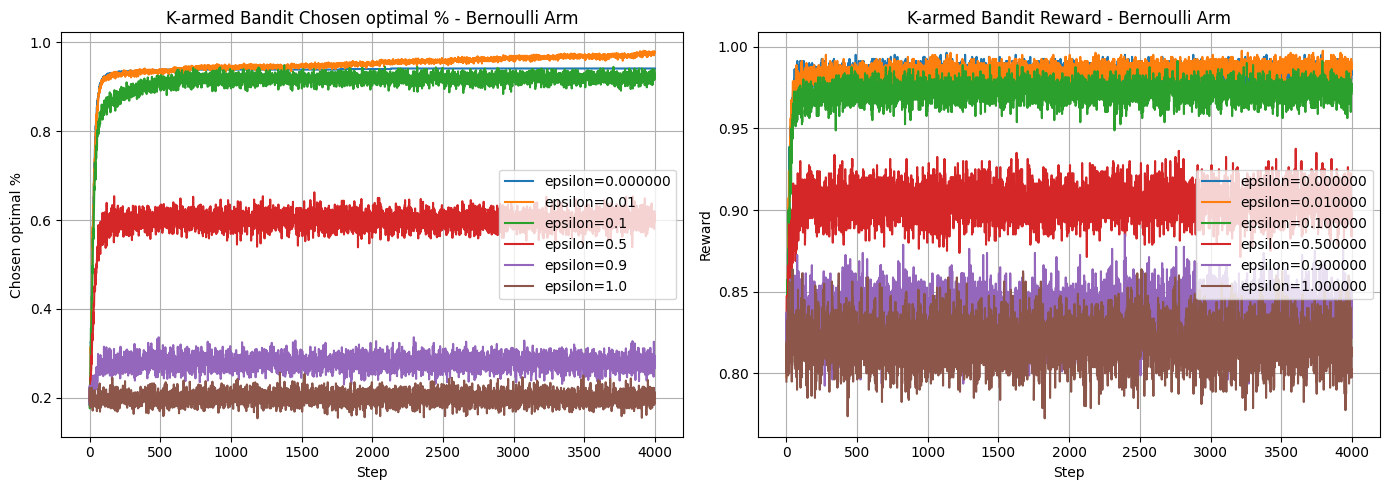

In [57]:
plot_results(mab_opt_bern_1, arm="Bernoulli", model="mab")

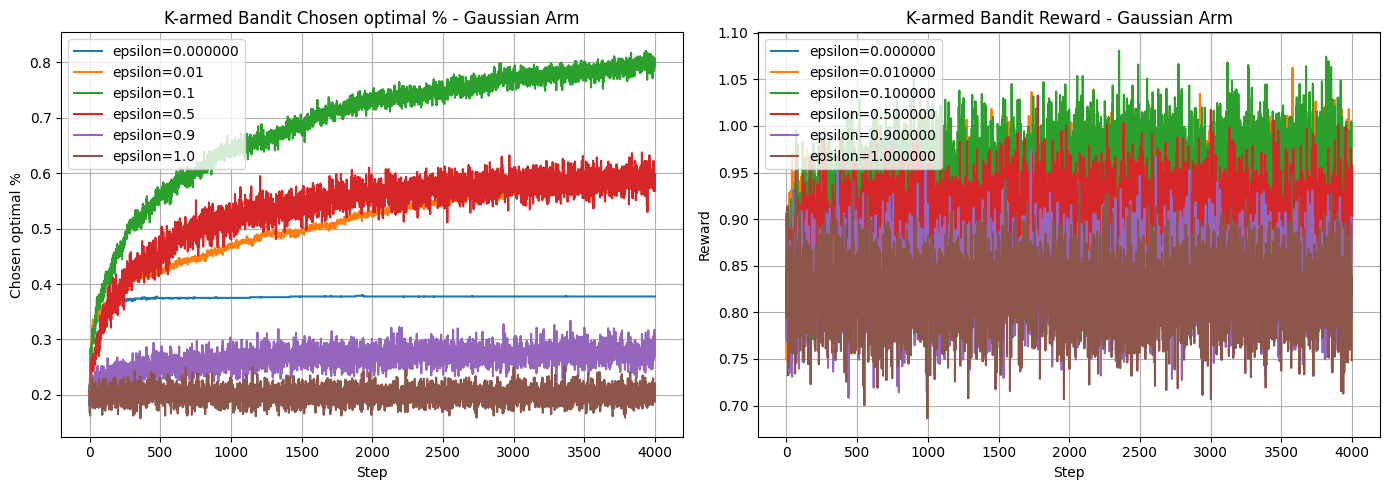

In [58]:
plot_results(mab_opt_gaus_1, arm="Gaussian", model="mab")

### $\alpha$=0.5

In [59]:
mab_opt_bern_half = procedure(fname="./eGreedyMAB_BernoulliArm_0.5_Optimistic_results.pkl", no_param=False)
mab_opt_gaus_half = procedure(fname="./eGreedyMAB_GaussianArm_0.5_Optimistic_results.pkl", no_param=False)

100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.11s/it]


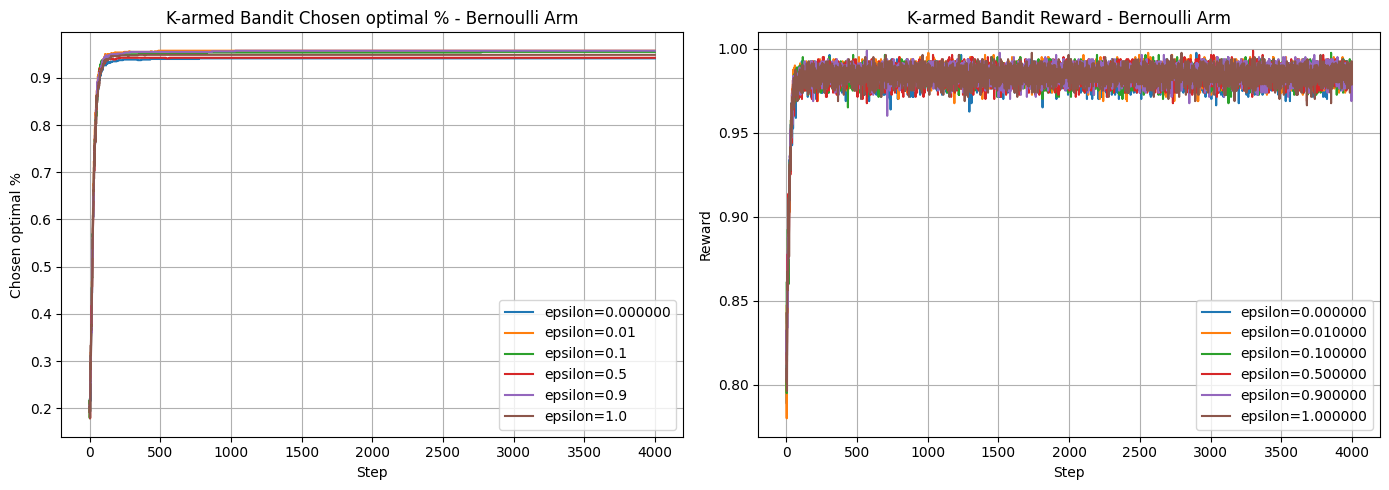

In [60]:
plot_results(mab_opt_bern_half, arm="Bernoulli", model="mab")

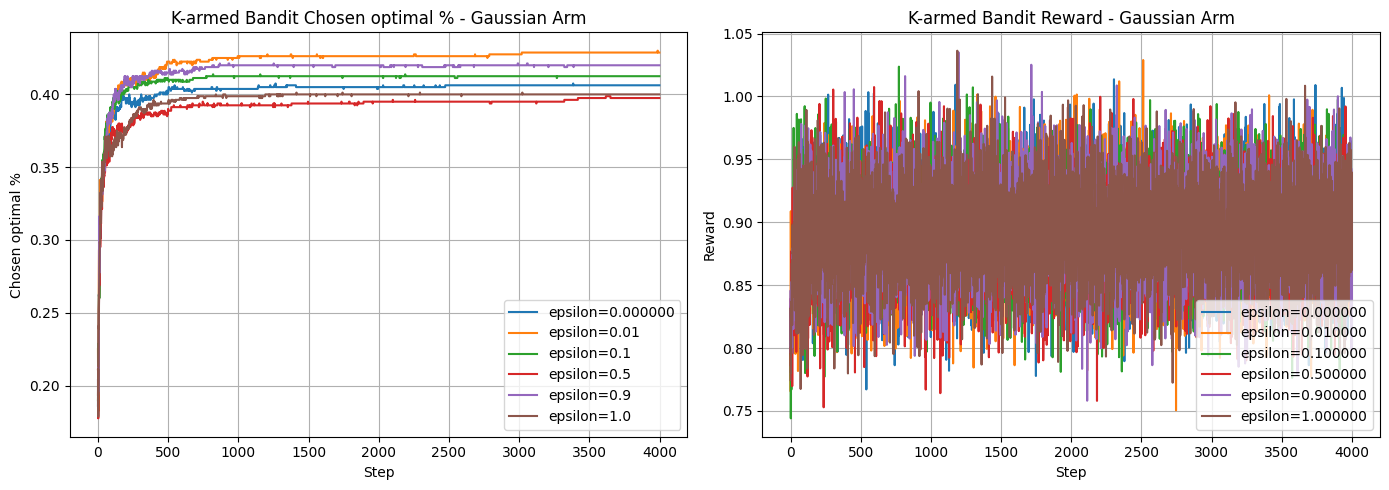

In [61]:
plot_results(mab_opt_gaus_half, arm="Gaussian", model="mab")

## Comparison - Naive vs Optimistic

### Bernoulli $\alpha$=1

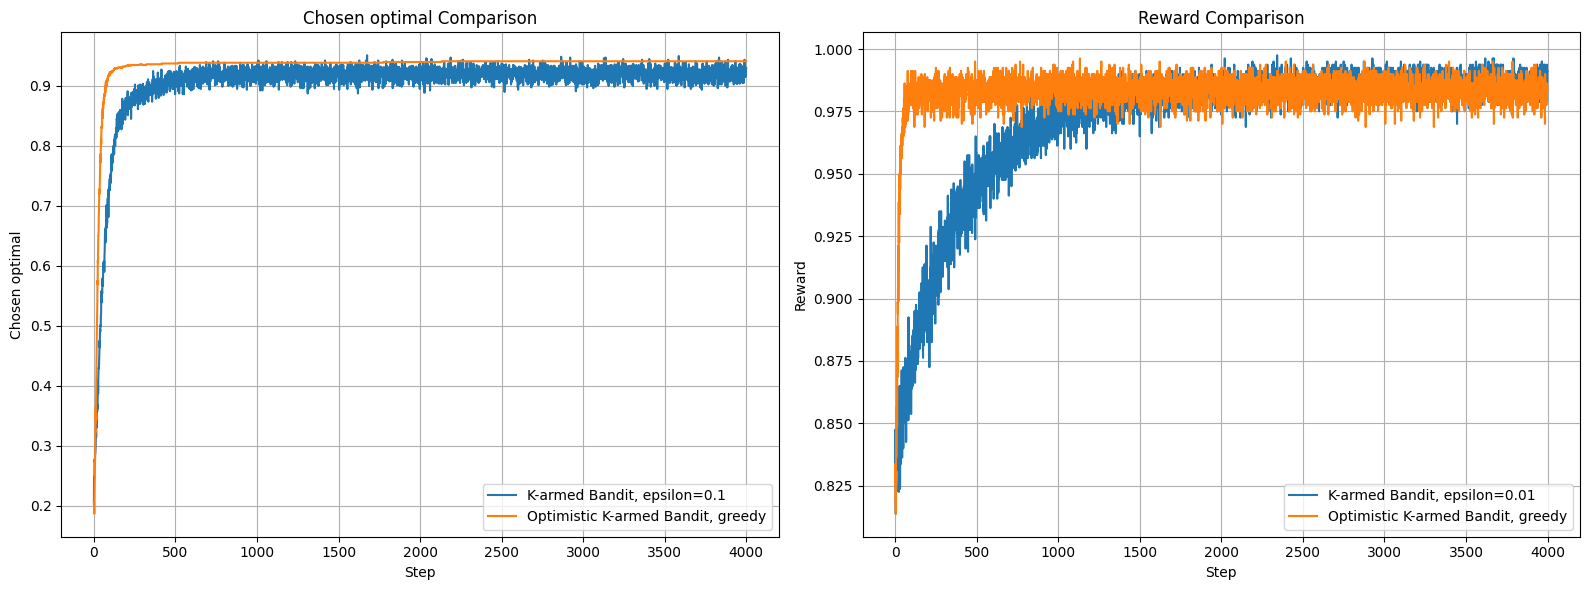

In [62]:
figsize = (16, 6)

model1, model2 = "mab", "mab"

column1 = 'chosen_optimal'
ylabel1 = getlabel(column1)
argmax1_col1, label1_col1 = summary(mab_bern_1, model1, column1, greedy=False, is_optimistic=False)
argmax2_col1, label2_col1 = summary(mab_opt_bern_1, model2, column1, greedy=True, is_optimistic=True)

column2 = 'reward'
ylabel2 = getlabel(column2)
argmax1_col2, label1_col2 = summary(mab_bern_1, model1, column2, greedy=False, is_optimistic=False)
argmax2_col2, label2_col2 = summary(mab_opt_bern_1, model2, column2, greedy=True, is_optimistic=True)

plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(mab_bern_1[argmax1_col1][column1], label=label1_col1)
plt.plot(mab_opt_bern_1[argmax2_col1][column1], label=label2_col1)
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(ylabel1)
plt.legend()
plt.title(f"{ylabel1} Comparison")

plt.subplot(122)
plt.plot(mab_bern_1[argmax1_col2][column2], label=label1_col2)
plt.plot(mab_opt_bern_1[argmax2_col2][column2], label=label2_col2)
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(ylabel2)
plt.legend()
plt.title(f"{ylabel2} Comparison")

plt.tight_layout()
plt.show()

### Bernoulli $\alpha$=0.5

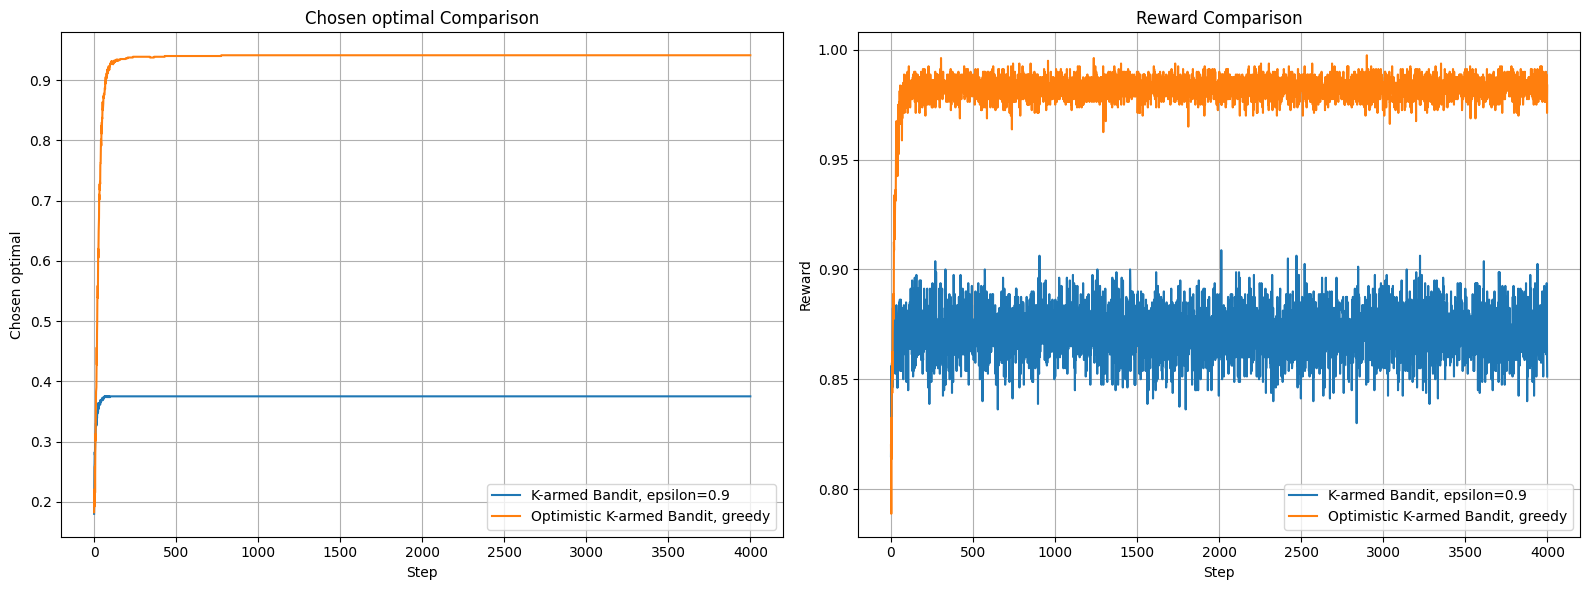

In [63]:
figsize = (16, 6)

model1, model2 = "mab", "mab"

column1 = 'chosen_optimal'
ylabel1 = getlabel(column1)
argmax1_col1, label1_col1 = summary(mab_bern_half, model1, column1, greedy=False, is_optimistic=False)
argmax2_col1, label2_col1 = summary(mab_opt_bern_half, model2, column1, greedy=True, is_optimistic=True)

column2 = 'reward'
ylabel2 = getlabel(column2)
argmax1_col2, label1_col2 = summary(mab_bern_half, model1, column2, greedy=False, is_optimistic=False)
argmax2_col2, label2_col2 = summary(mab_opt_bern_half, model2, column2, greedy=True, is_optimistic=True)

plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(mab_bern_half[argmax1_col1][column1], label=label1_col1)
plt.plot(mab_opt_bern_half[argmax2_col1][column1], label=label2_col1)
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(ylabel1)
plt.legend()
plt.title(f"{ylabel1} Comparison")

plt.subplot(122)
plt.plot(mab_bern_half[argmax1_col2][column2], label=label1_col2)
plt.plot(mab_opt_bern_half[argmax2_col2][column2], label=label2_col2)
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(ylabel2)
plt.legend()
plt.title(f"{ylabel2} Comparison")

plt.tight_layout()
plt.show()

### Gaussian $\alpha$=1

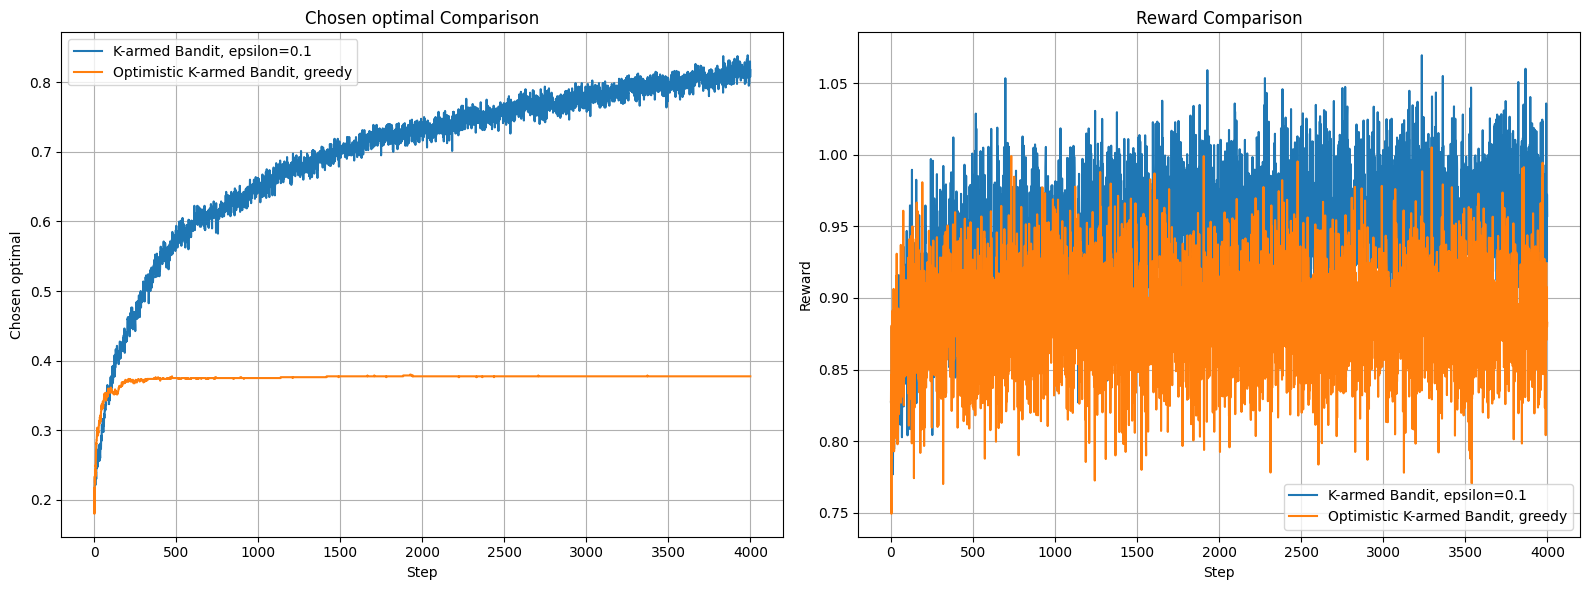

In [64]:
figsize = (16, 6)

model1, model2 = "mab", "mab"

column1 = 'chosen_optimal'
ylabel1 = getlabel(column1)
argmax1_col1, label1_col1 = summary(mab_gaus_1, model1, column1, greedy=False, is_optimistic=False)
argmax2_col1, label2_col1 = summary(mab_opt_gaus_1, model2, column1, greedy=True, is_optimistic=True)

column2 = 'reward'
ylabel2 = getlabel(column2)
argmax1_col2, label1_col2 = summary(mab_gaus_1, model1, column2, greedy=False, is_optimistic=False)
argmax2_col2, label2_col2 = summary(mab_opt_gaus_1, model2, column2, greedy=True, is_optimistic=True)

plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(mab_gaus_1[argmax1_col1][column1], label=label1_col1)
plt.plot(mab_opt_gaus_1[argmax2_col1][column1], label=label2_col1)
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(ylabel1)
plt.legend()
plt.title(f"{ylabel1} Comparison")

plt.subplot(122)
plt.plot(mab_gaus_1[argmax1_col2][column2], label=label1_col2)
plt.plot(mab_opt_gaus_1[argmax2_col2][column2], label=label2_col2)
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(ylabel2)
plt.legend()
plt.title(f"{ylabel2} Comparison")

plt.tight_layout()
plt.show()

### Gaussian $\alpha$=0.5

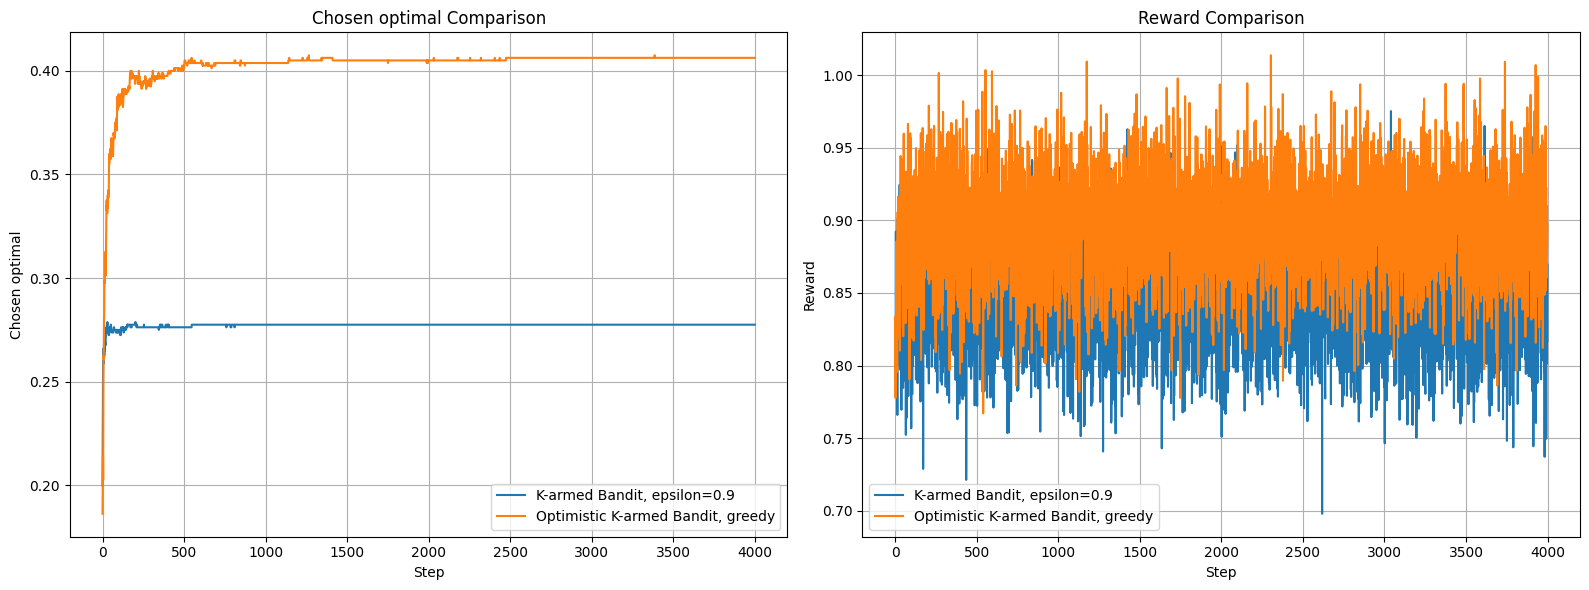

In [65]:
figsize = (16, 6)

model1, model2 = "mab", "mab"

column1 = 'chosen_optimal'
ylabel1 = getlabel(column1)
argmax1_col1, label1_col1 = summary(mab_gaus_half, model1, column1, greedy=False, is_optimistic=False)
argmax2_col1, label2_col1 = summary(mab_opt_gaus_half, model2, column1, greedy=True, is_optimistic=True)

column2 = 'reward'
ylabel2 = getlabel(column2)
argmax1_col2, label1_col2 = summary(mab_gaus_half, model1, column2, greedy=False, is_optimistic=False)
argmax2_col2, label2_col2 = summary(mab_opt_gaus_half, model2, column2, greedy=True, is_optimistic=True)

plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(mab_gaus_half[argmax1_col1][column1], label=label1_col1)
plt.plot(mab_opt_gaus_half[argmax2_col1][column1], label=label2_col1)
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(ylabel1)
plt.legend()
plt.title(f"{ylabel1} Comparison")

plt.subplot(122)
plt.plot(mab_gaus_half[argmax1_col2][column2], label=label1_col2)
plt.plot(mab_opt_gaus_half[argmax2_col2][column2], label=label2_col2)
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(ylabel2)
plt.legend()
plt.title(f"{ylabel2} Comparison")

plt.tight_layout()
plt.show()

# Explore-then-Commit

In [66]:
etc_bern_1 = procedure(fname="./ETC_BernoulliArm_1.0_Naive_results.pkl", no_param=False)
etc_gaus_1 = procedure(fname="./ETC_GaussianArm_1.0_Naive_results.pkl", no_param=False)

100%|██████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.02s/it]


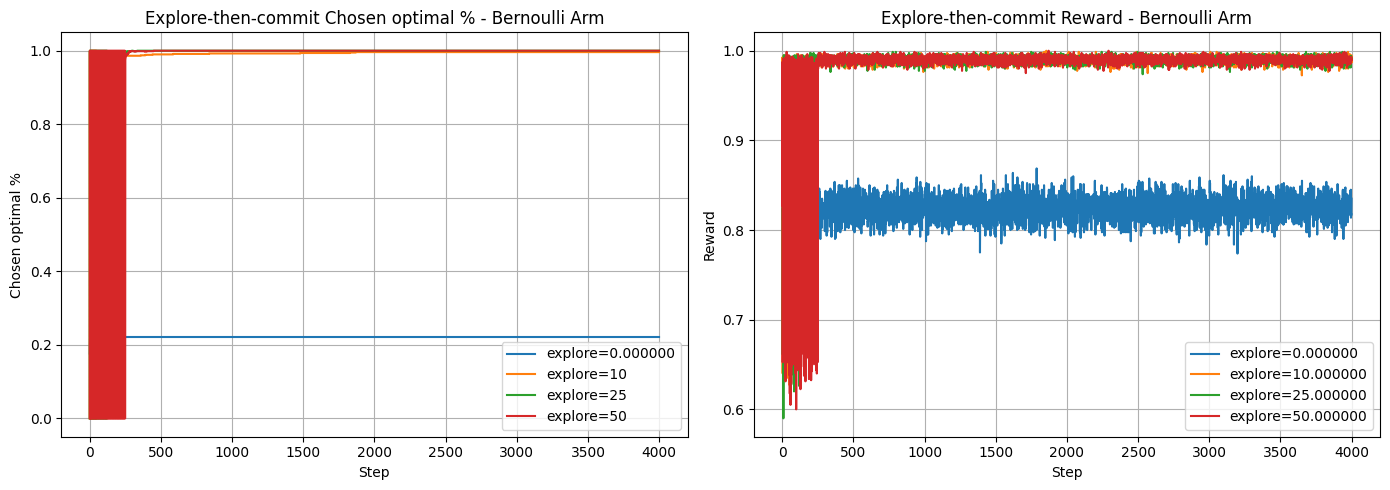

In [67]:
plot_results(etc_bern_1, arm="Bernoulli", model="etc")

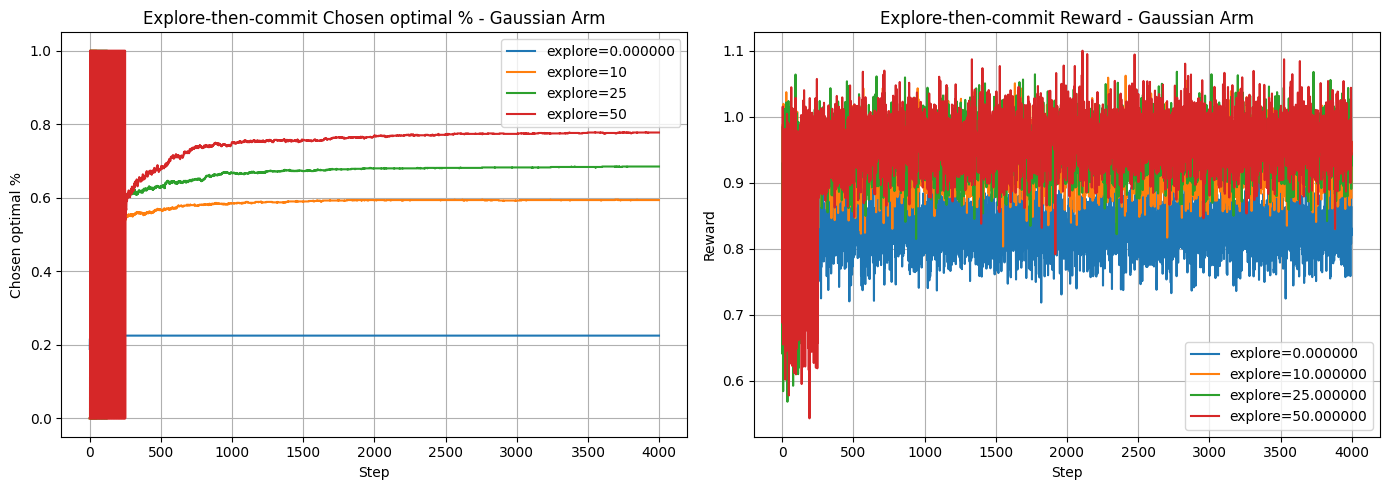

In [68]:
plot_results(etc_gaus_1, arm="Gaussian", model="etc")

# Thompson Sampling

In [69]:
ts_bern = procedure(fname="./ThompsonSampling_BernoulliArm_1.0_Naive_results.pkl", no_param=True)
ts_gaus = procedure(fname="./ThompsonSampling_GaussianArm_1.0_Naive_results.pkl", no_param=True)

100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.89s/it]


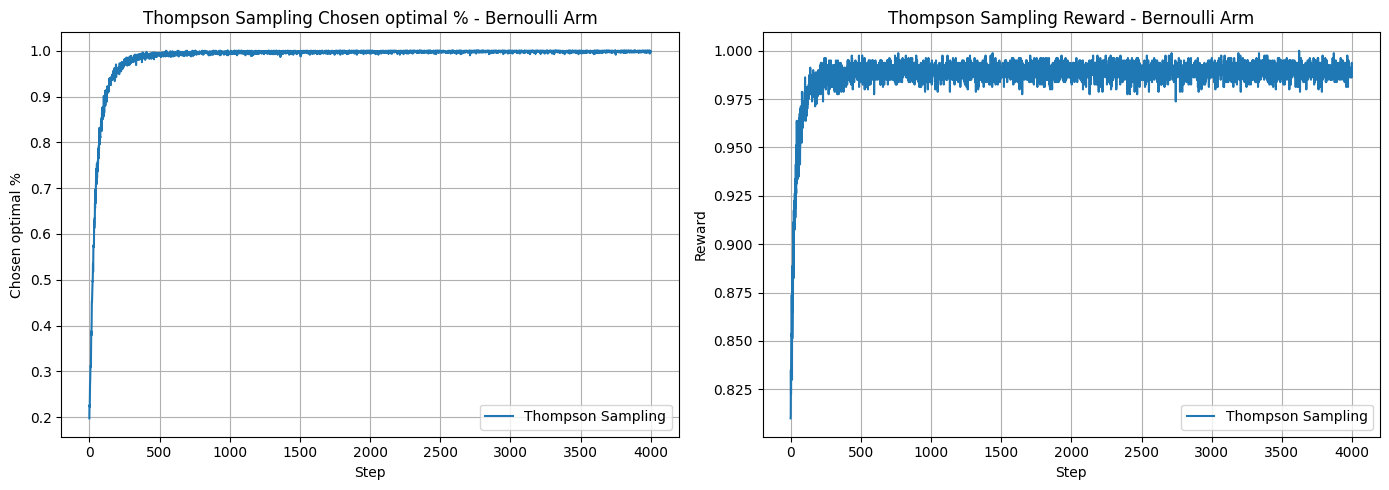

In [70]:
plot_results(ts_bern, arm="Bernoulli", model="thompson")

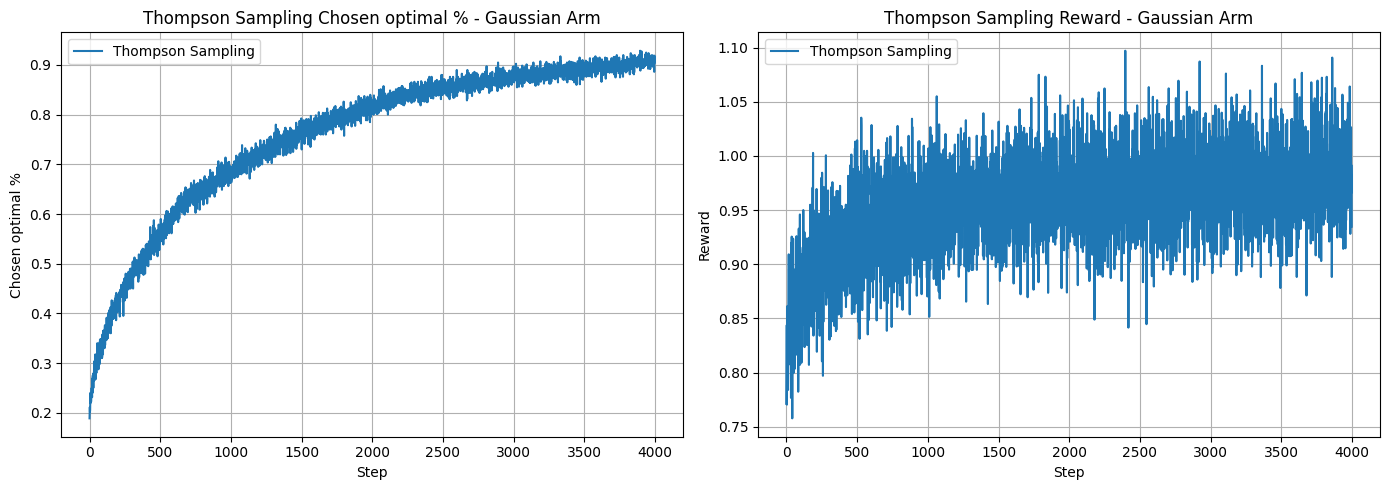

In [71]:
plot_results(ts_gaus, arm="Gaussian", model="thompson")

# UCB

## Naive

In [72]:
ucbnaive_bern_1 = procedure(fname="./UCBNaive_BernoulliArm_1.0_Naive_results.pkl", no_param=False)
ucbnaive_gaus_1 = procedure(fname="./UCBNaive_GaussianArm_1.0_Naive_results.pkl", no_param=False)

100%|██████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.01s/it]


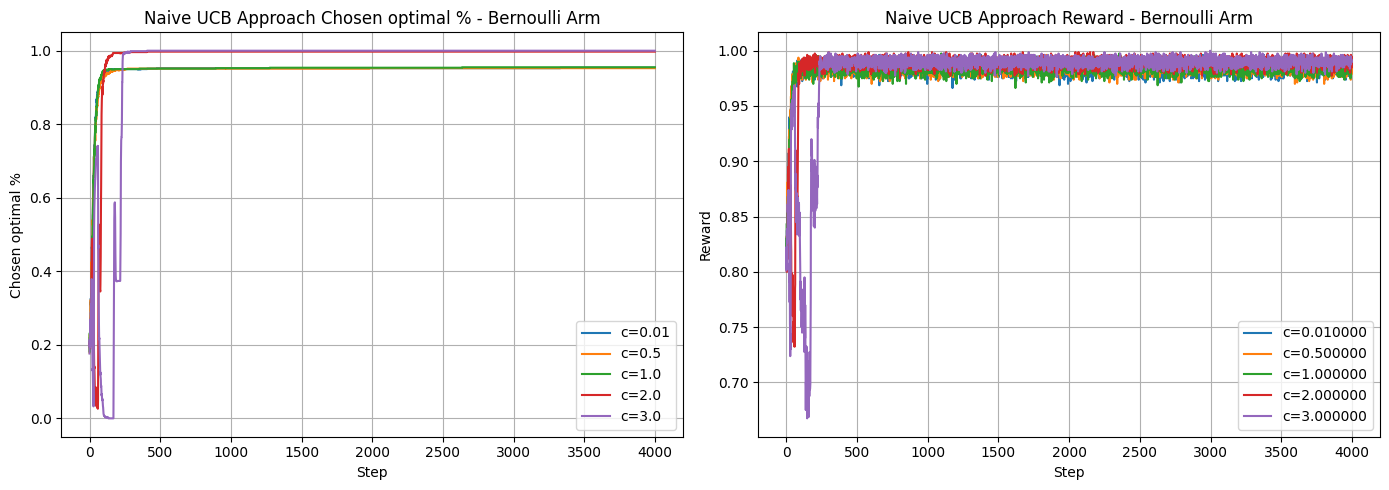

In [73]:
plot_results(ucbnaive_bern_1, arm="Bernoulli", model="ucbnaive")

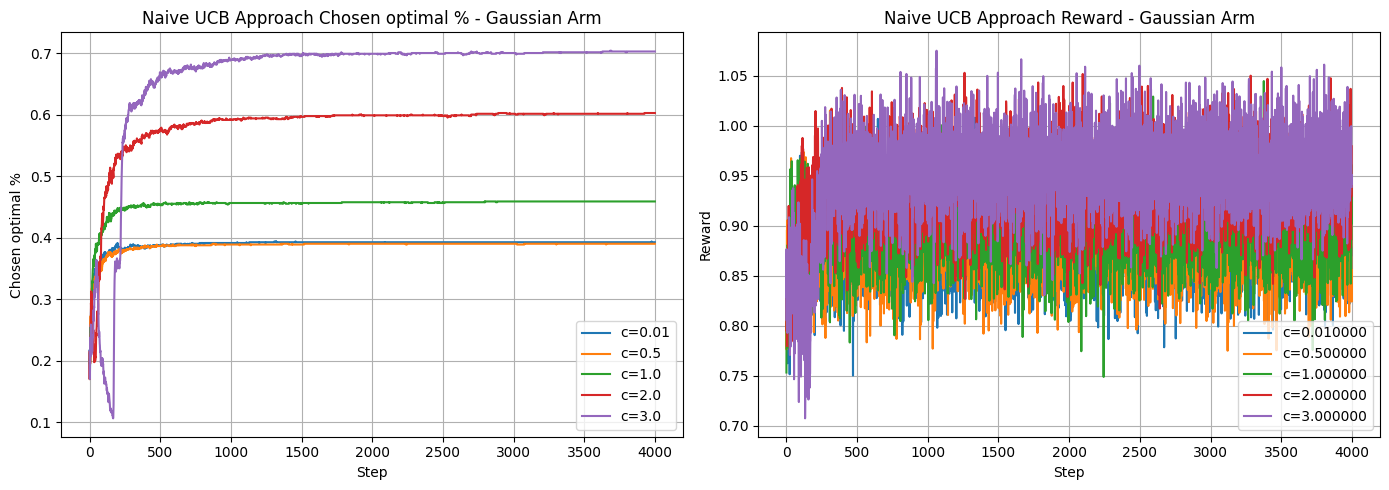

In [74]:
plot_results(ucbnaive_gaus_1, arm="Gaussian", model="ucbnaive")

## Delta

In [75]:
ucbdelta_bern_1 = procedure(fname="./UCBDelta_BernoulliArm_1.0_Naive_results.pkl", no_param=False)
ucbdelta_gaus_1 = procedure(fname="./UCBDelta_GaussianArm_1.0_Naive_results.pkl", no_param=False)

100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.03s/it]


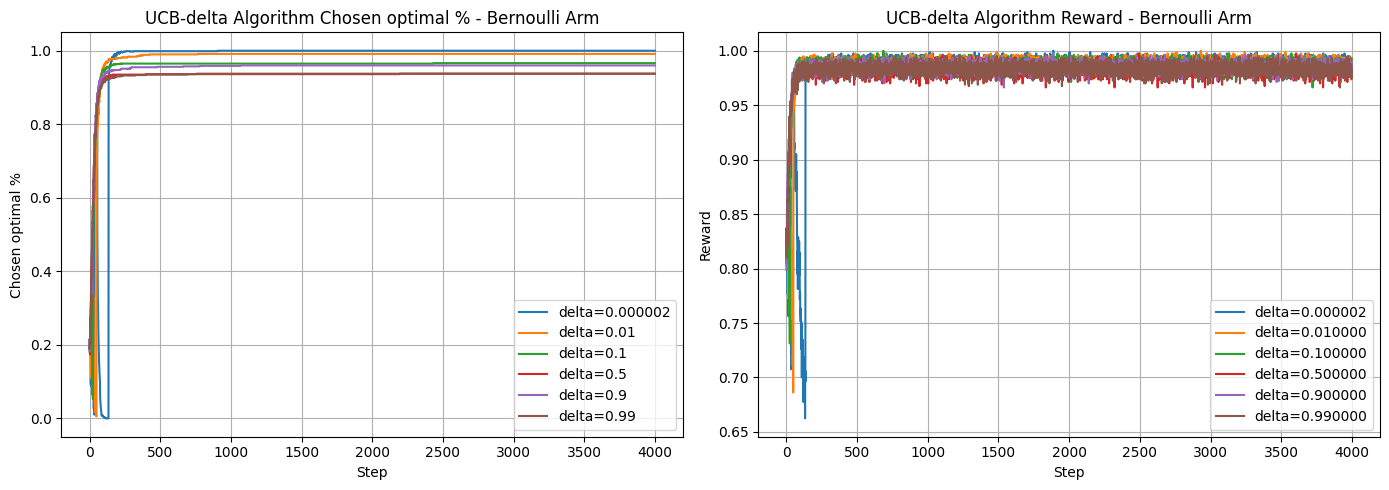

In [76]:
plot_results(ucbdelta_bern_1, arm="Bernoulli", model="ucbdelta")

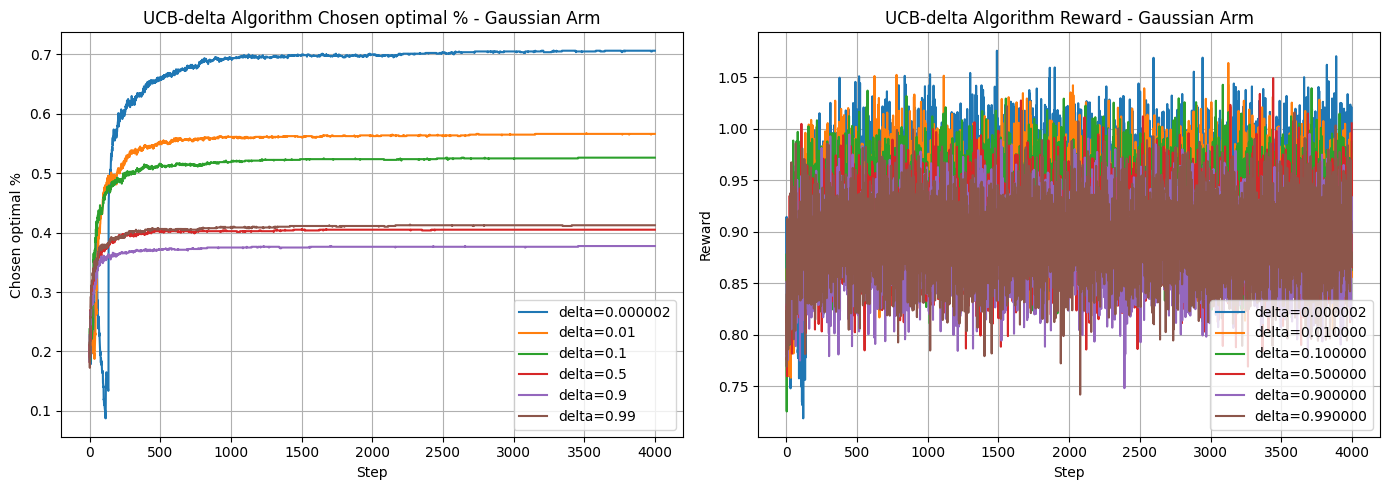

In [77]:
plot_results(ucbdelta_gaus_1, arm="Gaussian", model="ucbdelta")

## Asymptotically Optimal

In [78]:
ucbasym_bern_1 = procedure(fname="./UCBAsymptotic_BernoulliArm_1.0_Naive_results.pkl", no_param=True)
ucbasym_gaus_1 = procedure(fname="./UCBAsymptotic_GaussianArm_1.0_Naive_results.pkl", no_param=True)

100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.86s/it]


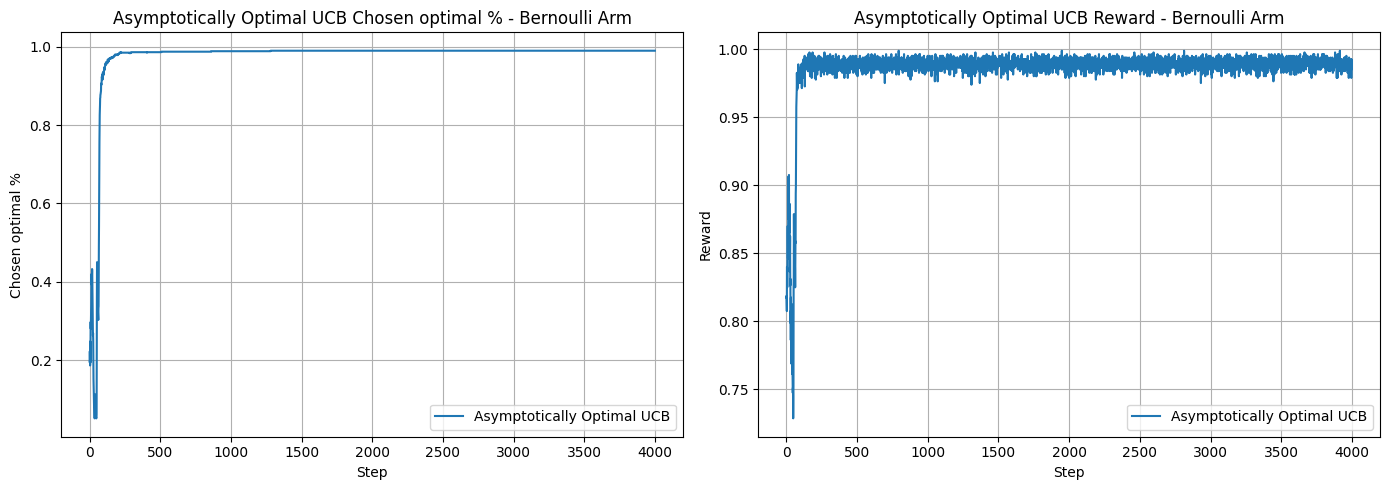

In [79]:
plot_results(ucbasym_bern_1, arm="Bernoulli", model="ucbasym")

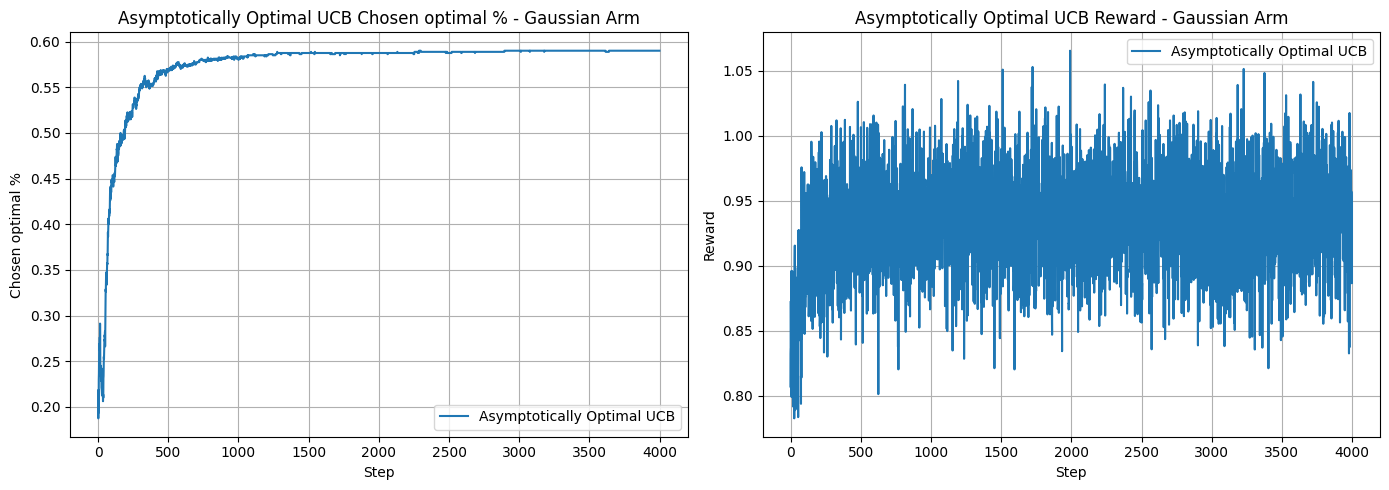

In [80]:
plot_results(ucbasym_gaus_1, arm="Gaussian", model="ucbasym")

## MOSS

In [81]:
ucbmoss_bern_1 = procedure(fname="./UCBMOSS_BernoulliArm_1.0_Naive_results.pkl", no_param=True)
ucbmoss_gaus_1 = procedure(fname="./UCBMOSS_GaussianArm_1.0_Naive_results.pkl", no_param=True)

100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


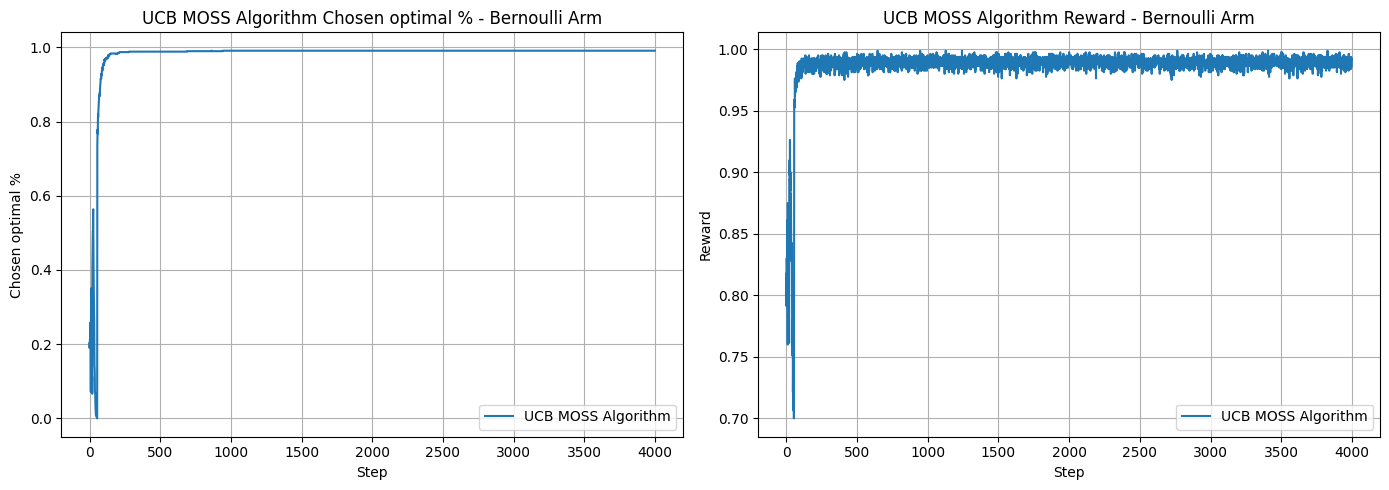

In [82]:
plot_results(ucbmoss_bern_1, arm="Bernoulli", model="ucbmoss")

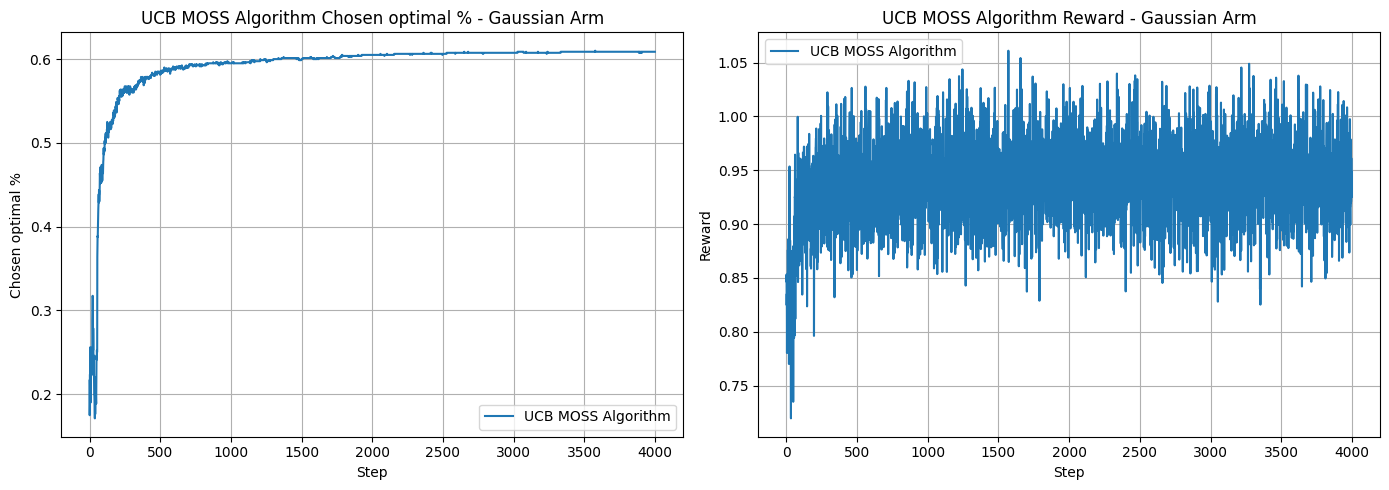

In [83]:
plot_results(ucbmoss_gaus_1, arm="Gaussian", model="ucbmoss")

## UCB Comparison

### Bernoulli Arm

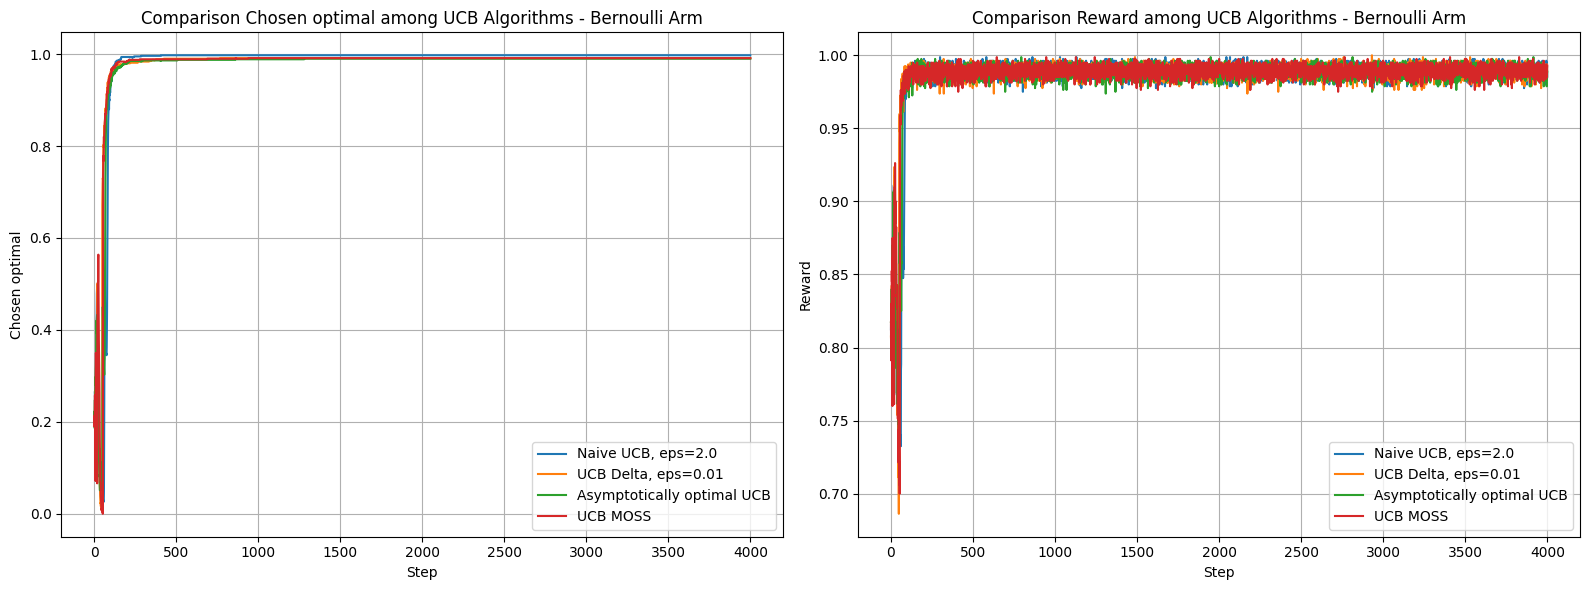

In [84]:
optimal = 'chosen_optimal'
reward = 'reward'

## find the best confidence term - naive approach
naive_mean_choices = [item[optimal].mean() for item in ucbnaive_bern_1]
naive_argmax = np.argmax(naive_mean_choices)

## find the best delta
delta_mean_choices = [item[optimal].mean() for item in ucbdelta_bern_1]
delta_argmax = np.argmax(delta_mean_choices)

naive_best_epsilon = ucbnaive_bern_1[naive_argmax]['param'].iloc[0]
delta_best_epsilon = ucbdelta_bern_1[delta_argmax]['param'].iloc[0]

figsize=(16, 6)
optimal_label = getlabel(optimal)
reward_label = getlabel(reward)

plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(ucbnaive_bern_1[naive_argmax][optimal], label=f"Naive UCB, eps={naive_best_epsilon}")
plt.plot(ucbdelta_bern_1[delta_argmax][optimal], label=f"UCB Delta, eps={delta_best_epsilon}")
plt.plot(ucbasym_bern_1[0][optimal], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_bern_1[0][optimal], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(optimal_label)
plt.legend()
plt.title(f"Comparison {optimal_label} among UCB Algorithms - Bernoulli Arm")

plt.subplot(122)
plt.plot(ucbnaive_bern_1[naive_argmax][reward], label=f"Naive UCB, eps={naive_best_epsilon}")
plt.plot(ucbdelta_bern_1[delta_argmax][reward], label=f"UCB Delta, eps={delta_best_epsilon}")
plt.plot(ucbasym_bern_1[0][reward], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_bern_1[0][reward], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(reward_label)
plt.legend()
plt.title(f"Comparison {reward_label} among UCB Algorithms - Bernoulli Arm")

plt.tight_layout()
plt.show()

### Gaussian Arm

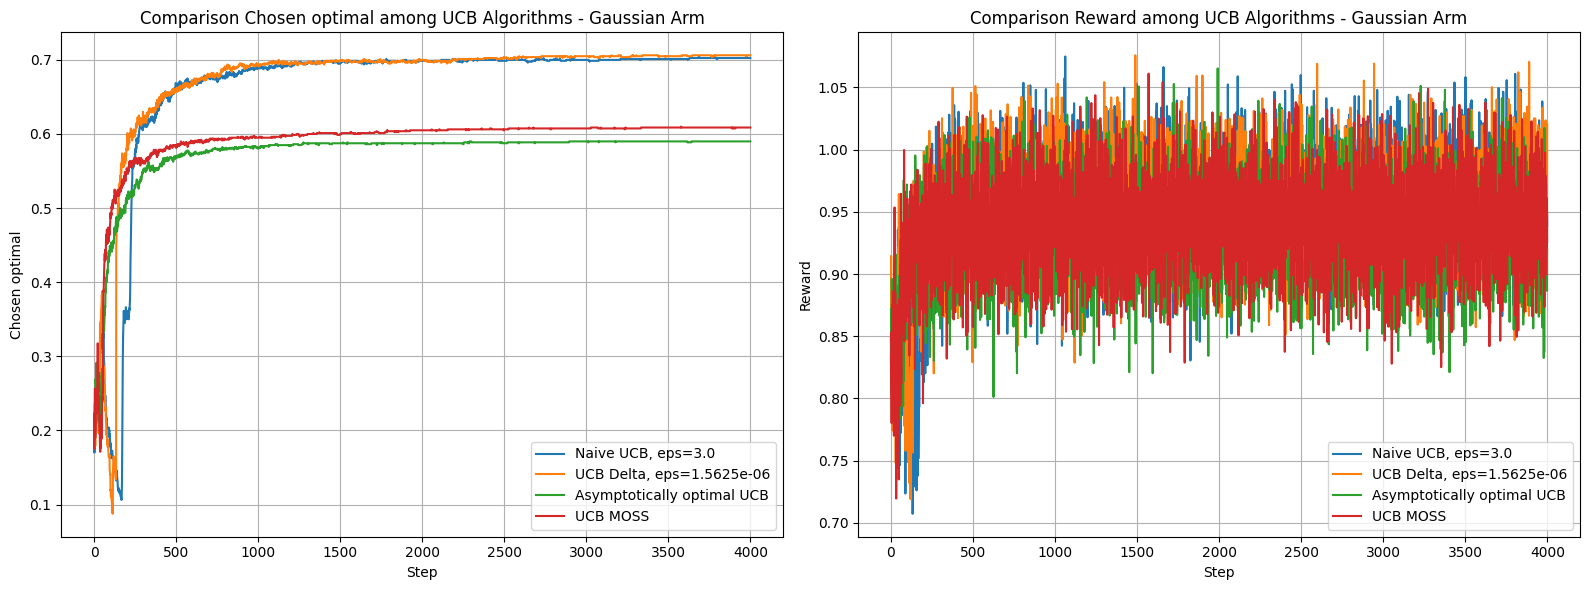

In [85]:
optimal = 'chosen_optimal'
reward = 'reward'

## find the best confidence term - naive approach
naive_mean_choices = [item[optimal].mean() for item in ucbnaive_gaus_1]
naive_argmax = np.argmax(naive_mean_choices)

## find the best delta
delta_mean_choices = [item[optimal].mean() for item in ucbdelta_gaus_1]
delta_argmax = np.argmax(delta_mean_choices)

naive_best_epsilon = ucbnaive_gaus_1[naive_argmax]['param'].iloc[0]
delta_best_epsilon = ucbdelta_gaus_1[delta_argmax]['param'].iloc[0]

figsize=(16, 6)
optimal_label = getlabel(optimal)
reward_label = getlabel(reward)

plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(ucbnaive_gaus_1[naive_argmax][optimal], label=f"Naive UCB, eps={naive_best_epsilon}")
plt.plot(ucbdelta_gaus_1[delta_argmax][optimal], label=f"UCB Delta, eps={delta_best_epsilon}")
plt.plot(ucbasym_gaus_1[0][optimal], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_gaus_1[0][optimal], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(optimal_label)
plt.legend()
plt.title(f"Comparison {optimal_label} among UCB Algorithms - Gaussian Arm")

plt.subplot(122)
plt.plot(ucbnaive_gaus_1[naive_argmax][reward], label=f"Naive UCB, eps={naive_best_epsilon}")
plt.plot(ucbdelta_gaus_1[delta_argmax][reward], label=f"UCB Delta, eps={delta_best_epsilon}")
plt.plot(ucbasym_gaus_1[0][reward], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_gaus_1[0][reward], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(reward_label)
plt.legend()
plt.title(f"Comparison {reward_label} among UCB Algorithms - Gaussian Arm")

plt.tight_layout()
plt.show()

# Comparison

## Bernoulli Arm

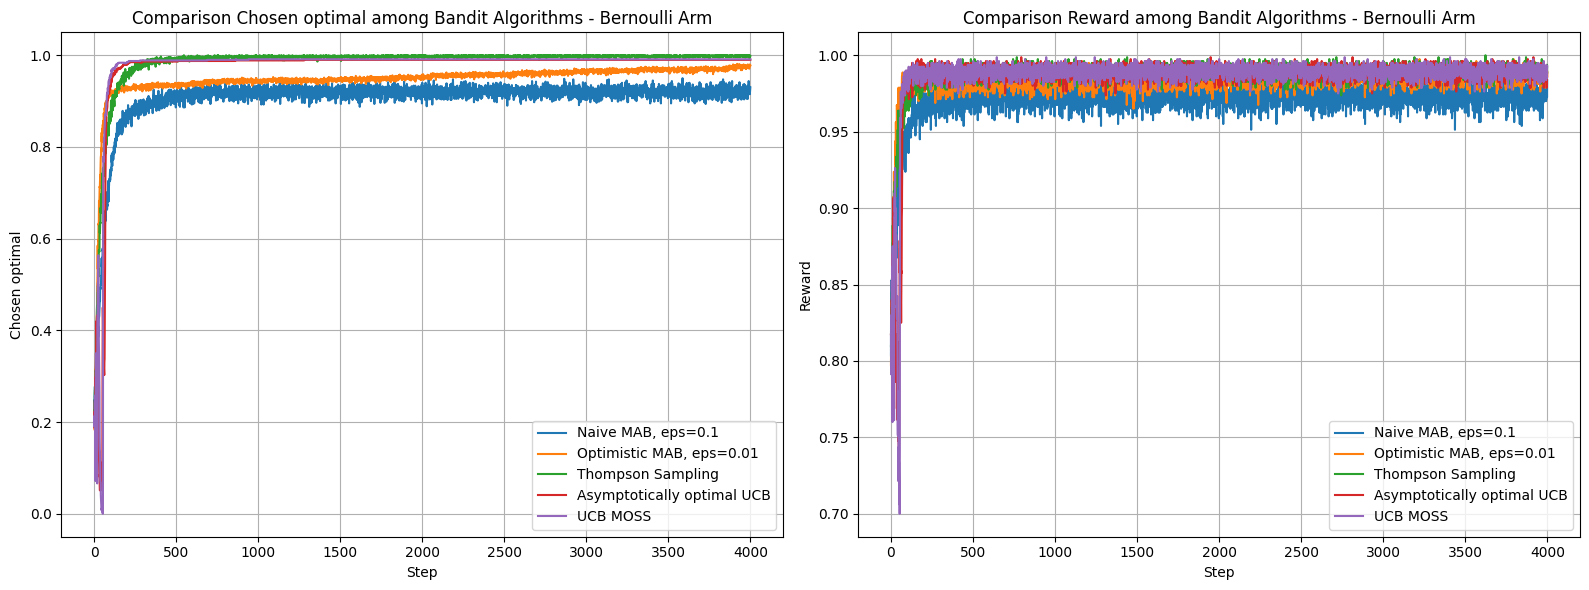

In [86]:
optimal = 'chosen_optimal'
reward = 'reward'

## find the best epsilon - naive approach
naive_mean_choices = [item[optimal].mean() for item in mab_bern_1]
naive_argmax = np.argmax(naive_mean_choices)

## find the best epsilon - optimistic approach
opt_mean_choices = [item[optimal].mean() for item in mab_opt_bern_1]
opt_argmax = np.argmax(opt_mean_choices)

naive_best_epsilon = mab_bern_1[naive_argmax]['param'].iloc[0]
opt_best_epsilon = mab_opt_bern_1[opt_argmax]['param'].iloc[0]

figsize=(16, 6)
optimal_label = getlabel(optimal)
reward_label = getlabel(reward)

plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(mab_bern_1[naive_argmax][optimal], label=f"Naive MAB, eps={naive_best_epsilon}")
plt.plot(mab_opt_bern_1[opt_argmax][optimal], label=f"Optimistic MAB, eps={opt_best_epsilon}")
plt.plot(ts_bern[0][optimal], label=f"Thompson Sampling")
plt.plot(ucbasym_bern_1[0][optimal], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_bern_1[0][optimal], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(optimal_label)
plt.legend()
plt.title(f"Comparison {optimal_label} among Bandit Algorithms - Bernoulli Arm")

plt.subplot(122)
plt.plot(mab_bern_1[naive_argmax][reward], label=f"Naive MAB, eps={naive_best_epsilon}")
plt.plot(mab_opt_bern_1[opt_argmax][reward], label=f"Optimistic MAB, eps={opt_best_epsilon}")
plt.plot(ts_bern[0][reward], label=f"Thompson Sampling")
plt.plot(ucbasym_bern_1[0][reward], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_bern_1[0][reward], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(reward_label)
plt.legend()
plt.title(f"Comparison {reward_label} among Bandit Algorithms - Bernoulli Arm")

plt.tight_layout()
plt.show()

## Gaussian Arm

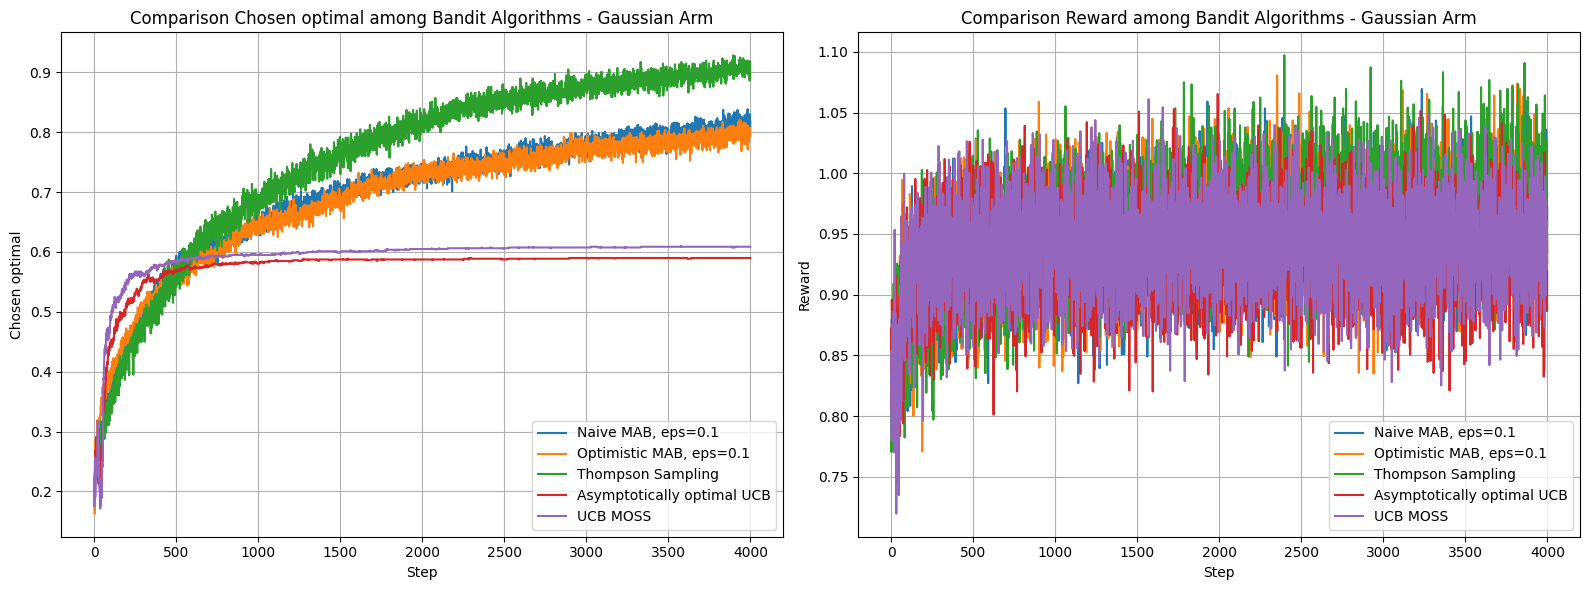

In [87]:
optimal = 'chosen_optimal'
reward = 'reward'

## find the best epsilon - naive approach
naive_mean_choices = [item[optimal].mean() for item in mab_gaus_1]
naive_argmax = np.argmax(naive_mean_choices)

## find the best epsilon - optimistic approach
opt_mean_choices = [item[optimal].mean() for item in mab_opt_gaus_1]
opt_argmax = np.argmax(opt_mean_choices)

naive_best_epsilon = mab_gaus_1[naive_argmax]['param'].iloc[0]
opt_best_epsilon = mab_opt_gaus_1[opt_argmax]['param'].iloc[0]

figsize=(16, 6)
optimal_label = getlabel(optimal)
reward_label = getlabel(reward)

plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(mab_gaus_1[naive_argmax][optimal], label=f"Naive MAB, eps={naive_best_epsilon}")
plt.plot(mab_opt_gaus_1[opt_argmax][optimal], label=f"Optimistic MAB, eps={opt_best_epsilon}")
plt.plot(ts_gaus[0][optimal], label=f"Thompson Sampling")
plt.plot(ucbasym_gaus_1[0][optimal], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_gaus_1[0][optimal], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(optimal_label)
plt.legend()
plt.title(f"Comparison {optimal_label} among Bandit Algorithms - Gaussian Arm")

plt.subplot(122)
plt.plot(mab_gaus_1[naive_argmax][reward], label=f"Naive MAB, eps={naive_best_epsilon}")
plt.plot(mab_opt_gaus_1[opt_argmax][reward], label=f"Optimistic MAB, eps={opt_best_epsilon}")
plt.plot(ts_gaus[0][reward], label=f"Thompson Sampling")
plt.plot(ucbasym_gaus_1[0][reward], label=f"Asymptotically optimal UCB")
plt.plot(ucbmoss_gaus_1[0][reward], label=f"UCB MOSS")
plt.grid(True)
plt.xlabel("Step")
plt.ylabel(reward_label)
plt.legend()
plt.title(f"Comparison {reward_label} among Bandit Algorithms - Gaussian Arm")

plt.tight_layout()
plt.show()